# Installing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Dropout, PReLU, ELU, ReLU
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
import optuna
import xgboost as xgb
from tqdm import tqdm
import gc
import shap
import statsmodels.api as sm
import os
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import brier_score_loss, mean_absolute_error, mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier
data_dir = '/home/yuki/kaggle/MNCAA_2021/Data/Stage2/'

In [4]:
#No.1 Basics
team = pd.read_csv(os.path.join(data_dir + 'MTeams.csv'))
season = pd.read_csv(os.path.join(data_dir + 'MSeasons.csv'))
seeds = pd.read_csv(os.path.join(data_dir + 'MNCAATourneySeeds.csv'))
compactResReg = pd.read_csv(os.path.join(data_dir + 'MRegularSeasonCompactResults.csv'))
compactResTour = pd.read_csv(os.path.join(data_dir + 'MNCAATourneyCompactResults.csv'))
sampleSub = pd.read_csv(os.path.join(data_dir + 'MSampleSubmissionStage2.csv'))

#No.2 Team Box Scores
detailResReg = pd.read_csv(os.path.join(data_dir + 'MRegularSeasonDetailedResults.csv'))
detailResTour = pd.read_csv(os.path.join(data_dir + 'MNCAATourneyDetailedResults.csv'))

#No.3 Geography
city = pd.read_csv(os.path.join(data_dir + 'Cities.csv'))
gameCity = pd.read_csv(os.path.join(data_dir + 'MGameCities.csv'))

#No.4 Public Rankings
teamRank = pd.read_csv(os.path.join(data_dir + 'MMasseyOrdinals.csv'))

#No.5 Supplements
coach = pd.read_csv(os.path.join(data_dir + 'MTeamCoaches.csv'))
conf = pd.read_csv(os.path.join(data_dir + 'Conferences.csv'))
teamConf = pd.read_csv(os.path.join(data_dir + 'MTeamConferences.csv'))
confTourGame = pd.read_csv(os.path.join(data_dir + 'MConferenceTourneyGames.csv'))
seconTeam = pd.read_csv(os.path.join(data_dir + 'MSecondaryTourneyTeams.csv'))
compactResSec = pd.read_csv(os.path.join(data_dir + 'MSecondaryTourneyCompactResults.csv'))
teamSpel = pd.read_csv(os.path.join(data_dir + 'MTeamSpellings.csv'), encoding='utf-8')
tourSlots = pd.read_csv(os.path.join(data_dir + 'MNCAATourneySlots.csv'))
seedRoundSlots = pd.read_csv(os.path.join(data_dir + 'MNCAATourneySeedRoundSlots.csv'))

In [50]:
import datetime
td = datetime.timedelta(132)
season['SelectSun'] = pd.to_datetime(season['DayZero']) + td

In [61]:
season

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ,SelectSun
0,1985,10/29/1984,East,West,Midwest,Southeast,1985-03-10
1,1986,10/28/1985,East,Midwest,Southeast,West,1986-03-09
2,1987,10/27/1986,East,Southeast,Midwest,West,1987-03-08
3,1988,11/2/1987,East,Midwest,Southeast,West,1988-03-13
4,1989,10/31/1988,East,West,Midwest,Southeast,1989-03-12
5,1990,10/30/1989,East,Midwest,Southeast,West,1990-03-11
6,1991,10/29/1990,East,Southeast,Midwest,West,1991-03-10
7,1992,11/4/1991,East,West,Midwest,Southeast,1992-03-15
8,1993,11/2/1992,East,Midwest,Southeast,West,1993-03-14
9,1994,11/1/1993,East,Southeast,Midwest,West,1994-03-13


In [3]:
#memo
#DayNum=132がSelection Sunday

# EDA

## No.1 Basics

In [20]:
#regural season compact result
#WLoc:勝ったチームがホームかアウェイかニュートラルか
#NumOT：OTの時間
compactResReg.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [21]:
len(compactResReg)

166880

In [22]:
#Tournament Compact Result
compactResTour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [23]:
len(compactResTour)

2251

In [16]:
#team
team.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2021
1,1102,Air Force,1985,2021
2,1103,Akron,1985,2021
3,1104,Alabama,1985,2021
4,1105,Alabama A&M,2000,2021


In [18]:
team['TeamID'].nunique()

371

In [24]:
#season
season.head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


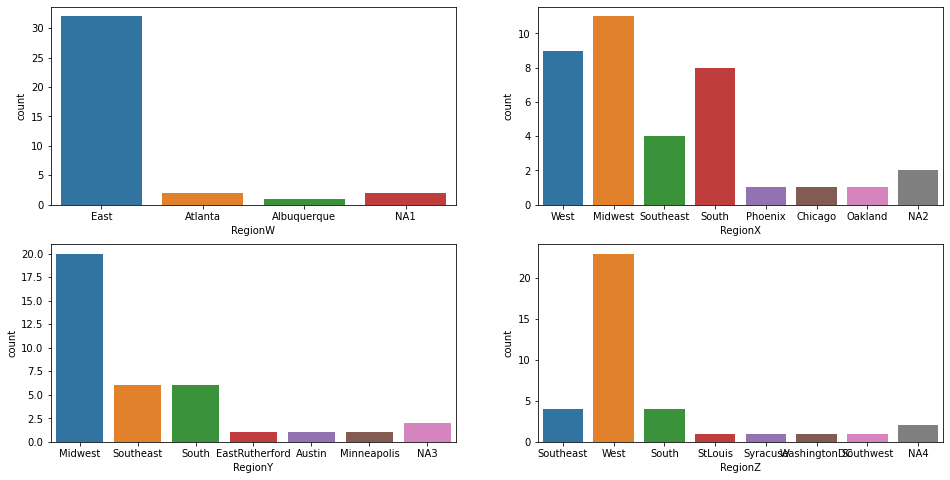

In [32]:
fig = plt.figure(figsize=(16,8))

#add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

sns.countplot(x=season['RegionW'], ax=ax1)
sns.countplot(x=season['RegionX'], ax=ax2)
sns.countplot(x=season['RegionY'], ax=ax3)
sns.countplot(x=season['RegionZ'], ax=ax4)

plt.show()

In [33]:
#seeds
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


## No.2 Team Box Scores

In [36]:
detailResReg.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [37]:
detailResTour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


## No.3 Gecography

In [38]:
city.head()

,CityID,City,State
0,4001,Abilene,TX
1,4002,Akron,OH
2,4003,Albany,NY
3,4004,Albuquerque,NM
4,4005,Allentown,PA


In [39]:
gameCity.head()

,Season,DayNum,WTeamID,LTeamID,CRType,CityID
0,2010,7,1143,1293,Regular,4027
1,2010,7,1314,1198,Regular,4061
2,2010,7,1326,1108,Regular,4080
3,2010,7,1393,1107,Regular,4340
4,2010,9,1143,1178,Regular,4027


In [40]:
gameCity['CRType'].unique()

array(['Regular', 'NCAA', 'Secondary'], dtype=object)

In [41]:
gameCity['Season'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

## No.4 Public Rankings

In [42]:
teamRank.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


/home/yuki/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='OrdinalRank', ylabel='Density'>

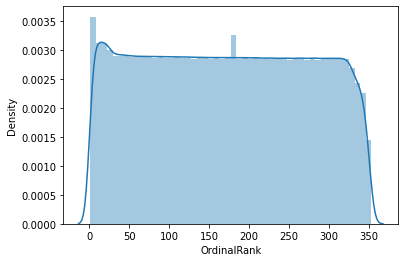

In [43]:
sns.distplot(teamRank['OrdinalRank'])

In [44]:
len(teamRank)

4120886

In [46]:
teamRank['SystemName'].nunique()

179

## No.5 Supplements

In [47]:
coach.head()

,Season,TeamID,FirstDayNum,LastDayNum,CoachName
0,1985,1102,0,154,reggie_minton
1,1985,1103,0,154,bob_huggins
2,1985,1104,0,154,wimp_sanderson
3,1985,1106,0,154,james_oliver
4,1985,1108,0,154,davey_whitney


In [48]:
coach['CoachName'].nunique()

1451

In [49]:
#Conferences
conf.head()

,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference


In [50]:
#MTeamConferences
teamConf.head()

,Season,TeamID,ConfAbbrev
0,1985,1102,wac
1,1985,1103,ovc
2,1985,1104,sec
3,1985,1106,swac
4,1985,1108,swac


In [51]:
#MConferenceTourneyGames
confTourGame.head()

,Season,ConfAbbrev,DayNum,WTeamID,LTeamID
0,2001,a_sun,121,1194,1144
1,2001,a_sun,121,1416,1240
2,2001,a_sun,122,1209,1194
3,2001,a_sun,122,1359,1239
4,2001,a_sun,122,1391,1273


In [53]:
#Secoundory Tournament Teams
seconTeam.head()

,Season,SecondaryTourney,TeamID
0,1985,NIT,1108
1,1985,NIT,1133
2,1985,NIT,1139
3,1985,NIT,1145
4,1985,NIT,1151


In [54]:
seconTeam['SecondaryTourney'].nunique()

4

In [55]:
len(seconTeam)

1642

In [56]:
#Secondary Tournament Compact Result
compactResSec.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,SecondaryTourney
0,1985,136,1151,67,1155,65,H,0,NIT
1,1985,136,1153,77,1245,61,H,0,NIT
2,1985,136,1201,79,1365,76,H,0,NIT
3,1985,136,1231,79,1139,57,H,0,NIT
4,1985,136,1249,78,1222,71,H,0,NIT


In [57]:
#Team Spell
teamSpel.head()

,TeamNameSpelling,TeamID
0,a&m-corpus chris,1394
1,a&m-corpus christi,1394
2,abilene chr,1101
3,abilene christian,1101
4,abilene-christian,1101


In [58]:
#Tournament Slot
slots.head()

,Season,Slot,StrongSeed,WeakSeed
0,1985,R1W1,W01,W16
1,1985,R1W2,W02,W15
2,1985,R1W3,W03,W14
3,1985,R1W4,W04,W13
4,1985,R1W5,W05,W12


In [59]:
#Tournament Seed Round Slots
seedRoundSlots.head()

,Seed,GameRound,GameSlot,EarlyDayNum,LateDayNum
0,W01,1,R1W1,136,137
1,W01,2,R2W1,138,139
2,W01,3,R3W1,143,144
3,W01,4,R4W1,145,146
4,W01,5,R5WX,152,152


In [108]:
# チームの勝敗にどのような要因が絡んでいるか

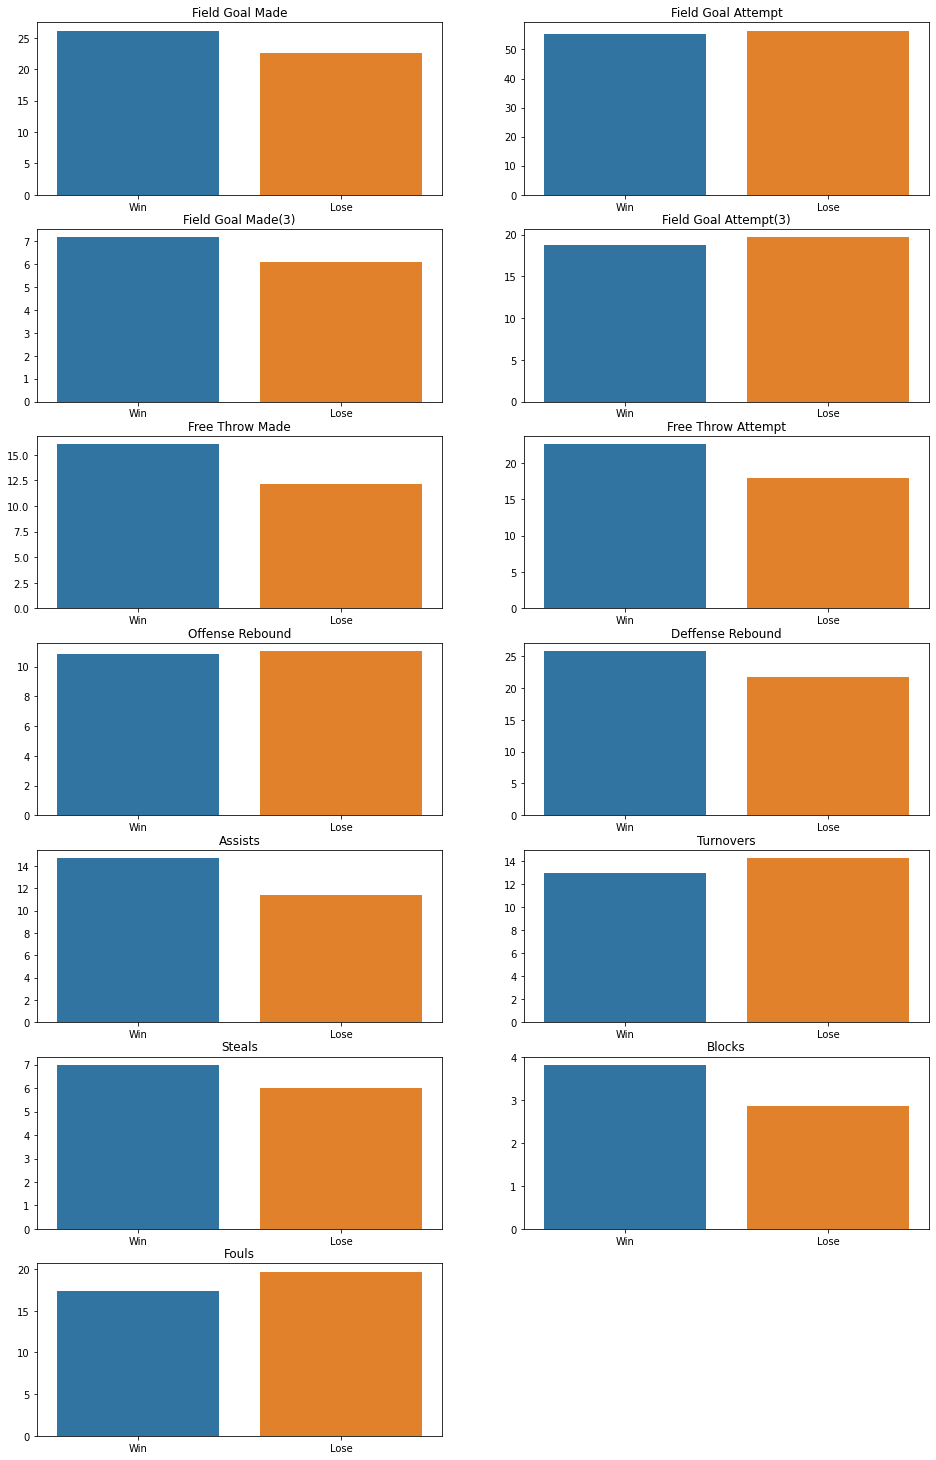

In [101]:
fig = plt.figure(figsize=(16, 26))

ax1 = fig.add_subplot(7, 2, 1)
ax2 = fig.add_subplot(7, 2, 2)
ax3 = fig.add_subplot(7, 2, 3)
ax4 = fig.add_subplot(7, 2, 4)
ax5 = fig.add_subplot(7, 2, 5)
ax6 = fig.add_subplot(7, 2, 6)
ax7 = fig.add_subplot(7, 2, 7)
ax8 = fig.add_subplot(7, 2, 8)
ax9 = fig.add_subplot(7, 2, 9)
ax10 = fig.add_subplot(7, 2, 10)
ax11 = fig.add_subplot(7, 2, 11)
ax12 = fig.add_subplot(7, 2, 12)
ax13 = fig.add_subplot(7, 2, 13)

sns.barplot(['Win', 'Lose'], [detailResReg['WFGM'].mean(), detailResReg['LFGM'].mean()], ax=ax1)
ax1.set_title('Field Goal Made')
sns.barplot(['Win', 'Lose'], [detailResReg['WFGA'].mean(), detailResReg['LFGA'].mean()], ax=ax2)
ax2.set_title('Field Goal Attempt')
sns.barplot(['Win', 'Lose'], [detailResReg['WFGM3'].mean(), detailResReg['LFGM3'].mean()], ax=ax3)
ax3.set_title('Field Goal Made(3)')
sns.barplot(['Win', 'Lose'], [detailResReg['WFGA3'].mean(), detailResReg['LFGA3'].mean()], ax=ax4)
ax4.set_title('Field Goal Attempt(3)')
sns.barplot(['Win', 'Lose'], [detailResReg['WFTM'].mean(), detailResReg['LFTM'].mean()], ax=ax5)
ax5.set_title('Free Throw Made')
sns.barplot(['Win', 'Lose'], [detailResReg['WFTA'].mean(), detailResReg['LFTA'].mean()], ax=ax6)
ax6.set_title('Free Throw Attempt')
sns.barplot(['Win', 'Lose'], [detailResReg['WOR'].mean(), detailResReg['LOR'].mean()], ax=ax7)
ax7.set_title('Offense Rebound')
sns.barplot(['Win', 'Lose'], [detailResReg['WDR'].mean(), detailResReg['LDR'].mean()], ax=ax8)
ax8.set_title('Deffense Rebound')
sns.barplot(['Win', 'Lose'], [detailResReg['WAst'].mean(), detailResReg['LAst'].mean()], ax=ax9)
ax9.set_title('Assists')
sns.barplot(['Win', 'Lose'], [detailResReg['WTO'].mean(), detailResReg['LTO'].mean()], ax=ax10)
ax10.set_title('Turnovers')
sns.barplot(['Win', 'Lose'], [detailResReg['WStl'].mean(), detailResReg['LStl'].mean()], ax=ax11)
ax11.set_title('Steals')
sns.barplot(['Win', 'Lose'], [detailResReg['WBlk'].mean(), detailResReg['LBlk'].mean()], ax=ax12)
ax12.set_title('Blocks')
sns.barplot(['Win', 'Lose'], [detailResReg['WPF'].mean(), detailResReg['LPF'].mean()], ax=ax13)
ax13.set_title('Fouls')

plt.show()

## Spread dataの読み込み

In [6]:
spread_df=[]
years_list = [20,19,18,17,16,15,14,13,12,11,10,'09','08','07','06','05','04','03']
year_int = 2021
for year in years_list:
    #Note: 18 refers to 2019 and so on
    temp_spread_df = pd.read_csv("./Data/Point_spreads/ncaabb" + str(year) + ".csv")
    temp_spread_df['Season'] = year_int
    year_int = year_int-1    
    if year==20:
        spread_df = temp_spread_df
    else:
        spread_df = spread_df.append(temp_spread_df)

In [7]:
spread_df['home'] = spread_df['home'].str.lower()
spread_df['road'] = spread_df['road'].str.lower()

In [8]:
spread_df

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,lineseven,linepig,linepom,linemass,linerpi,linegreen,lineash,lineargh,linemarkov,linesauce
0,NaN,abilene christian,70,east tennessee st.,47,6.5,-5.46,-7.34,-7.34,-7.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11/25/2020,alabama,81,jacksonville st.,57,20.5,17.53,16.94,16.94,16.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/25/2020,arkansas,142,miss valley st.,62,36.5,31.78,30.21,30.21,30.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11/25/2020,arkansas-little rock,71,prairie view,66,14,7.70,7.31,7.31,7.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11/25/2020,boston college,67,villanova,76,-14,-13.40,-13.53,-13.53,-13.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2839,03/30/2004,iowa st.,81,rutgers,84,2.0,1.22,1.50,1.25,1.74,...,NaN,NaN,0.81,1.73,-0.40,1.06,NaN,0.25,1.45,1.11
2840,04/01/2004,michigan,62,rutgers,55,5.5,2.06,1.51,0.46,2.44,...,NaN,NaN,2.08,1.80,-0.07,1.26,NaN,2.00,2.79,1.25
2841,04/03/2004,duke,78,connecticut,79,-2.0,2.85,2.85,2.24,3.94,...,NaN,NaN,1.92,3.54,2.55,2.33,NaN,3.00,3.65,3.57
2842,04/03/2004,oklahoma st.,67,georgia tech,67,4.5,2.05,1.99,3.58,0.52,...,NaN,NaN,2.47,2.62,2.40,1.66,NaN,3.00,-0.07,1.62


In [9]:
spread_df.groupby('Season').count()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,lineseven,linepig,linepom,linemass,linerpi,linegreen,lineash,lineargh,linemarkov,linesauce
Season,,,,,,,,,,,,,,,,,,,,,
2004,2844,2844,2844,2844,2844,2844,2844,2844,2844,2844,...,0,0,2844,2844,2844,2844,0,2844,2844,2844
2005,3007,3007,3007,3007,3007,3007,3007,3007,3007,3007,...,0,0,3007,0,3007,3007,3007,3007,0,0
2006,2964,2964,2940,2964,2957,2942,2964,2964,2964,2964,...,0,0,2964,0,2777,2758,790,0,0,0
2007,3340,3340,3329,3340,3340,3337,3340,3340,3340,3340,...,0,0,284,0,2653,2650,1418,0,0,0
2008,3431,3431,3246,3431,3385,3268,3431,3431,3431,3431,...,0,0,0,0,846,2659,0,0,0,0
2009,3243,3243,3056,3243,3232,3224,3243,3243,3243,3243,...,0,0,0,0,0,0,0,0,0,0
2010,3576,3576,3529,3576,3571,3555,3576,3576,3576,3576,...,0,0,0,0,0,0,0,0,0,0
2011,3631,3631,3503,3631,3624,3498,3631,3631,3631,3631,...,0,2828,2124,3149,0,0,0,0,0,0
2012,3573,3573,3435,3573,3573,3567,3573,3573,3572,3573,...,0,3113,2414,1864,0,0,0,0,0,0


In [10]:
# Match Team IDs to data
teamSpel = pd.read_csv('Data/MTeamSpellings.csv')
teamSpel.head()

,TeamNameSpelling,TeamID
0,a&m-corpus chris,1394
1,a&m-corpus christi,1394
2,abilene chr,1101
3,abilene christian,1101
4,abilene-christian,1101


In [11]:
team_list = ['home','road']
for team in team_list:
    spread_df = pd.merge(spread_df, teamSpel, left_on=[team], right_on = ['TeamNameSpelling'], how='left')
    if team=='home':
        spread_df.rename(columns={'TeamID': 'HTeamID'}, inplace=True)
    if team=='road':
        spread_df.rename(columns={'TeamID': 'RTeamID'}, inplace=True)
    spread_df = spread_df.drop(['TeamNameSpelling'], axis=1)

In [12]:
spread_df[spread_df['HTeamID'].isnull()]

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,linepom,linemass,linerpi,linegreen,lineash,lineargh,linemarkov,linesauce,HTeamID,RTeamID
4627,11/25/2019,chaminade,63,kansas,93,-37,-32.59,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1242.0
4672,11/26/2019,chaminade,48,ucla,74,-21.5,-22.10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1417.0
4733,11/27/2019,chaminade,77,georgia,80,-26,-22.98,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208.0
27010,11/24/2014,chaminade,68,pittsburgh,81,-16,-15.35,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1338.0
27047,11/25/2014,chaminade,85,byu,121,-16,-20.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1140.0
27083,11/26/2014,alaska anchorage,62,pacific,71,-3.5,-6.48,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1334.0
27090,11/26/2014,chaminade,60,missouri,74,-14,-14.17,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1281.0
27152,11/28/2014,alaska anchorage,51,sw missouri st.,55,-7,-10.06,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1283.0
27202,11/29/2014,alaska anchorage,65,rice,54,NaN,-2.42,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1349.0


In [19]:
#欠損しているチームを自分で追加する
newSpell = pd.DataFrame({'TeamNameSpelling':['cal st. bakersfield', 'ut rio grande valley', 
                                             'liu', 'southeast missouri st.', 'illinois chicago', 
                                             'louisiana monroe', 'st. francis ny', 'st. francis pa', 
                                             'tarleton st.', 'dixie st.', 'tennessee martin', 
                                             'texas a&m corpus chris', 'bethune cookman', 
                                             'arkansas pine bluff', 'maryland eastern shore', 
                                             'mississippi valley st.', 'texas tech ', 'indiana ', 
                                             'oklahoma ', 'wichita st. ', 'utah st. ', 'cincinnati ', 
                                             'richmond ', 'n.c. state ', 'louisiana lafayette', 
                                             'texas pan american', 'arkansas little rock', 
                                             'winston salem st.', 'southwest missouri st.', 
                                             'southwest texas st.', 'texas a&m; corpus chris', 
                                             'st. louis', 'nevada las vegas', 'louisiana st.', 
                                             'texas el paso', 'wisconsin green bay', 
                                             'iupu fort wayne', 'nj inst of technology', 
                                             'virginia military inst', 'wisconsin milwaukee', 
                                             'md baltimore county', 'missouri kansas city', 
                                             'nj tech', 'wisconsin-milwaukee', 'texas st.', 
                                              "st. peter''s", "florida gulf coas", "arkansas-little r", 
                                            ], 
                         'TeamID':[1167, 1410, 1254, 1369, 1227, 1419, 1383, 1384, 1470, 1469, 
                                   1404, 1394, 1126, 1115, 1271, 1290, 1403, 1231, 1328, 1455, 
                                   1429, 1153, 1350, 1301, 1418, 1410, 1114, 1445, 1283, 1402, 
                                   1394, 1387, 1424, 1261, 1431, 1453, 1236, 1312, 1440, 1454, 
                                   1420, 1282, 1312, 1454, 1402, 1389, 1195, 1114]})
teamSpel_new = pd.concat([teamSpel, newSpell], axis=0).drop_duplicates().reset_index(drop=True)

In [33]:
teamSpel_new.to_csv('/home/yuki/kaggle/MNCAA_2021/Data/MTeamSpellings.csv', index=False)
#kp_df.to_csv('Data/CreatedData/kp_all.csv', index=False)
#kp_df.to_csv('Data/kp_all.csv', index=False)

In [10]:
spread_df.head()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,linerpi,linegreen,lineash,lineargh,linemarkov,linesauce,Unnamed: 0_x,HTeamID,Unnamed: 0_y,RTeamID
0,NaN,abilene christian,70,east tennessee st.,47,6.5,-5.46,-7.34,-7.34,-7.34,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1101.0,240.0,1190.0
1,11/25/2020,alabama,81,jacksonville st.,57,20.5,17.53,16.94,16.94,16.94,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1104.0,392.0,1240.0
2,11/25/2020,arkansas,142,miss valley st.,62,36.5,31.78,30.21,30.21,30.21,...,NaN,NaN,NaN,NaN,NaN,NaN,49.0,1116.0,519.0,1290.0
3,11/25/2020,arkansas-little rock,71,prairie view,66,14,7.70,7.31,7.31,7.31,...,NaN,NaN,NaN,NaN,NaN,NaN,53.0,1114.0,740.0,1341.0
4,11/25/2020,boston college,67,villanova,76,-14,-13.40,-13.53,-13.53,-13.53,...,NaN,NaN,NaN,NaN,NaN,NaN,89.0,1130.0,1062.0,1437.0


Note: change to home and road team and score

In [13]:
spread_df.loc[spread_df['hscore']>spread_df['rscore'], 'WTeamID'] = spread_df['HTeamID']
spread_df.loc[spread_df['hscore']<spread_df['rscore'], 'LTeamID'] = spread_df['HTeamID']

spread_df.loc[spread_df['hscore']>spread_df['rscore'], 'WScore'] = spread_df['hscore']
spread_df.loc[spread_df['hscore']<spread_df['rscore'], 'LScore'] = spread_df['hscore']

In [14]:
spread_df.loc[spread_df['rscore']>spread_df['hscore'], 'WTeamID'] = spread_df['RTeamID']
spread_df.loc[spread_df['rscore']<spread_df['hscore'], 'LTeamID'] = spread_df['RTeamID']

spread_df.loc[spread_df['rscore']>spread_df['hscore'], 'WScore'] = spread_df['rscore']
spread_df.loc[spread_df['rscore']<spread_df['hscore'], 'LScore'] = spread_df['rscore']

In [15]:
spread_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['WTeamID','LTeamID','WScore','LScore','line'])
spread_df = spread_df[spread_df['WScore'] != "."]
spread_df = spread_df[spread_df['LScore'] != "."]
spread_df = spread_df[spread_df['line'] != "."]

In [16]:
spread_df['line'].value_counts(dropna=False)

3.5       1841
3.0       1840
2.5       1835
5.5       1802
5.0       1787
          ... 
-146.0       1
-18.5        1
-79.5        1
-17.0        1
40.0         1
Name: line, Length: 273, dtype: int64

In [17]:
spread_df.columns

Index(['date', 'home', 'hscore', 'road', 'rscore', 'line', 'lineavg',
       'linesag', 'linesage', 'linesagp', 'linesaggm', 'linemoore', 'lineopen',
       'linedok', 'linefox', 'std', 'linepugh', 'linedonc', 'neutral',
       'linetalis', 'lineespn', 'linepir', 'linepiw', 'linepib', 'line7ot',
       'lineer', 'linedd', 'linemassey', 'linedunk', 'lineround',
       'lineteamrnks', 'Season', 'lineashby', 'lineprophet', 'lineseven',
       'linepig', 'linepom', 'linemass', 'linerpi', 'linegreen', 'lineash',
       'lineargh', 'linemarkov', 'linesauce', 'HTeamID', 'RTeamID', 'WTeamID',
       'LTeamID', 'WScore', 'LScore'],
      dtype='object')

In [18]:
#drop spreads with bad coverage
spread_df = spread_df.drop(['line7ot','lineargh','lineash','lineashby','linedd',
                            'linedunk','lineer','linegreen','linemarkov','linemass',
                            'linepib','linepig','linepir','linepiw','linepom','lineprophet',
                            'linerpi','lineround','linesauce','lineseven',
                            'lineteamrnks','linetalis','lineespn','linemassey','linedonc',
                            'linesaggm','std','linepugh','linefox','linedok','lineopen'], axis=1)

In [19]:
spread_df.isnull().sum()

date            1
home            0
hscore       1090
road            0
rscore        177
line          511
lineavg       103
linesag       167
linesage      168
linesagp      167
linemoore     498
neutral      5995
Season          0
HTeamID         9
RTeamID         1
WTeamID      1188
LTeamID      1194
WScore       1186
LScore       1186
dtype: int64

In [20]:
spread_df.head()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,linemoore,neutral,Season,HTeamID,RTeamID,WTeamID,LTeamID,WScore,LScore
0,NaN,abilene christian,70,east tennessee st.,47,6.5,-5.46,-7.34,-7.34,-7.34,1.46,1.0,2021,1101.0,1190.0,1101.0,1190.0,70,47
1,11/25/2020,alabama,81,jacksonville st.,57,20.5,17.53,16.94,16.94,16.94,19.64,0.0,2021,1104.0,1240.0,1104.0,1240.0,81,57
2,11/25/2020,arkansas,142,miss valley st.,62,36.5,31.78,30.21,30.21,30.21,29.45,0.0,2021,1116.0,1290.0,1116.0,1290.0,142,62
3,11/25/2020,arkansas-little rock,71,prairie view,66,14,7.70,7.31,7.31,7.31,11.05,1.0,2021,1114.0,1341.0,1114.0,1341.0,71,66
4,11/25/2020,boston college,67,villanova,76,-14,-13.40,-13.53,-13.53,-13.53,-14.79,1.0,2021,1130.0,1437.0,1437.0,1130.0,76,67


In [21]:
spread_df.dropna(subset=['line'])

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,linemoore,neutral,Season,HTeamID,RTeamID,WTeamID,LTeamID,WScore,LScore
0,NaN,abilene christian,70,east tennessee st.,47,6.5,-5.46,-7.34,-7.34,-7.34,1.46,1.0,2021,1101.0,1190.0,1101.0,1190.0,70,47
1,11/25/2020,alabama,81,jacksonville st.,57,20.5,17.53,16.94,16.94,16.94,19.64,0.0,2021,1104.0,1240.0,1104.0,1240.0,81,57
2,11/25/2020,arkansas,142,miss valley st.,62,36.5,31.78,30.21,30.21,30.21,29.45,0.0,2021,1116.0,1290.0,1116.0,1290.0,142,62
3,11/25/2020,arkansas-little rock,71,prairie view,66,14,7.70,7.31,7.31,7.31,11.05,1.0,2021,1114.0,1341.0,1114.0,1341.0,71,66
4,11/25/2020,boston college,67,villanova,76,-14,-13.40,-13.53,-13.53,-13.53,-14.79,1.0,2021,1130.0,1437.0,1437.0,1130.0,76,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68033,03/30/2004,iowa st.,81,rutgers,84,2.0,1.22,1.50,1.25,1.74,1.61,NaN,2004,1235.0,1353.0,1353.0,1235.0,84,81
68034,04/01/2004,michigan,62,rutgers,55,5.5,2.06,1.51,0.46,2.44,4.47,NaN,2004,1276.0,1353.0,1276.0,1353.0,62,55
68035,04/03/2004,duke,78,connecticut,79,-2.0,2.85,2.85,2.24,3.94,1.43,NaN,2004,1181.0,1163.0,1163.0,1181.0,79,78
68036,04/03/2004,oklahoma st.,67,georgia tech,67,4.5,2.05,1.99,3.58,0.52,3.08,NaN,2004,1329.0,1210.0,NaN,NaN,NaN,NaN


In [22]:
spread_df.to_csv('Data/spreads_all.csv', index=False)

## Ken Pom Dataの読み込み

In [23]:
#WebからKenPomデータを取得してくるスクリプト
def extract_kp(url, col=2):
    import requests
    data = pd.read_html(url, header=1)
    kp = data[col].dropna()
    kp = kp.drop(kp[kp['Conf']=='Conf'].index).reset_index(drop=True)

    kp = kp[['Team', 'Conf', 'AdjEM', 'AdjO', 'AdjD', 'AdjT', 'Luck', 
        'AdjEM.1', 'OppO', 'OppD', 'AdjEM.3']].rename(columns={
        'Team':'team', 'Conf':'conf', 'AdjEM':'adjem', 'AdjO':'adjo', 'AdjD':'adjd', 
        'AdjT':'adjt', 'Luck':'luck', 'AdjEM.1':'sche', 'OppO':'oppo', 'OppD':'oppd', 
        'AdjEM.3':'regsche'
    }).reset_index(drop=True)

    kp['team'] = kp['team'].str.lower()
    kp['team'] = kp['team'].apply(remove_astarisk)
    kp['team'] = kp['team'].apply(remove_seed)
    kp['team'] = kp['team'].apply(remove_colon)
    kp['team'] = kp['team'].apply(remove_space)
    kp['team'] = kp['team'].apply(remove_colon)
    kp['adjem'] = kp['adjem'].apply(translate)
    kp['adjo'] = kp['adjo'].astype('float')
    kp['adjd'] = kp['adjd'].astype('float')
    kp['adjt'] = kp['adjt'].astype('float')
    kp['luck'] = kp['luck'].apply(translate)
    kp['sche'] = kp['sche'].apply(translate)
    kp['oppo'] = kp['oppo'].astype('float')
    kp['oppd'] = kp['oppd'].astype('float')
    kp['regsche'] = kp['regsche'].apply(translate)
    return kp

def translate(x):
    sign = x[0]
    num = float(x[1:])
    if sign == '-':
        num = num*(-1)
    return num

def remove_astarisk(x):
    if '*'in(x):
        return x[:-3]
    else:
        return x

def remove_colon(x):
    last_char = x[-1]
    if last_char == ";":
        x = x[:-1]
    return x

def remove_seed(x):
    last_char = x[-1]
    if last_char == " ":
        x = x[:-1]
    elif last_char in ['1','2','3','4','5','6','7','8','9','0']:
        x = x[:-2]
    return x

def remove_space(x):
    last_char = x[-1]
    if last_char == " ":
        x = x[:-1]
    return x

In [24]:
#古いフォーマットのKenpom
def extract_kp_old(url, col=2):
    import requests
    data = pd.read_html(url, header=1)
    kp = data[col].dropna()
    kp = kp.drop(kp[kp['Conf']=='Conf'].index).reset_index(drop=True)

    kp = kp[['Team', 'Conf', 'AdjO', 'AdjD', 'AdjT', 'Luck', 
        'OppO', 'OppD',]].rename(columns={
        'Team':'team', 'Conf':'conf', 'AdjO':'adjo', 'AdjD':'adjd', 
        'AdjT':'adjt', 'Luck':'luck', 'OppO':'oppo', 'OppD':'oppd', 
    }).reset_index(drop=True)

    kp['team'] = kp['team'].str.lower()
    kp['team'] = kp['team'].apply(remove_astarisk)
    kp['team'] = kp['team'].apply(remove_seed)
    kp['team'] = kp['team'].apply(remove_colon)
    kp['team'] = kp['team'].apply(remove_space)
    kp['team'] = kp['team'].apply(remove_colon)
    kp['adjo'] = kp['adjo'].astype('float')
    kp['adjd'] = kp['adjd'].astype('float')
    kp['adjt'] = kp['adjt'].astype('float')
    kp['luck'] = kp['luck'].apply(translate)
    kp['oppo'] = kp['oppo'].astype('float')
    kp['oppd'] = kp['oppd'].astype('float')
    return kp

In [26]:
url_2021 = "https://kenpom.com/index.php"
url_2019 = 'https://web.archive.org/web/20190319000001/https://kenpom.com/'
url_2018 = 'https://web.archive.org/web/20180312133836/https://kenpom.com/'
url_2017 = 'https://web.archive.org/web/20170314003320/http://kenpom.com/'
url_2016 = 'https://web.archive.org/web/20160314134726/http://kenpom.com/'
url_2015 = 'https://web.archive.org/web/20150316212936/http://kenpom.com/'
url_2014 = 'https://web.archive.org/web/20140318100454/http://kenpom.com:80/'
url_2013 = 'https://web.archive.org/web/20130318221134/http://kenpom.com/'
url_2012 = 'https://web.archive.org/web/20120311165019/http://kenpom.com:80/'
url_2011 = 'https://web.archive.org/web/20110311233233/http://www.kenpom.com:80/'
url_2010 = 'https://web.archive.org/web/20100304023540/http://kenpom.com/rate.php'
kp = extract_kp(url_2021, col=0)
print(len(kp))

357


In [29]:
tmp = kp.merge(teamSpel, left_on='team', right_on='TeamNameSpelling', how='left')
tmp[tmp['TeamID'].isnull()]

,team,conf,adjem,adjo,adjd,adjt,luck,sche,oppo,oppd,regsche,TeamNameSpelling,TeamID


In [33]:
year=2021
kp.to_csv('Data/Ken_Pom/KP_{}.csv'.format(year), index=False)

In [248]:
year=2011
kp_full = pd.read_csv('Data/Ken_Pom/KP_{}_final.csv'.format(year))
kp_merge = merge_with_full(kp, kp_full)

In [249]:
kp_merge

,team,conf,adjem,adjo,adjd,adjt,luck,sche,oppo,oppd,regsche
0,ohio st.,B10,33.47,125.4,88.4,66.0,0.043,8.82,107.4,98.3,-4.08
1,duke,ACC,28.42,118.8,87.2,70.1,0.006,8.43,106.0,97.4,3.48
2,kansas,B12,28.38,119.8,88.3,69.6,0.071,7.75,106.1,98.7,-0.29
3,texas,B12,25.93,114.0,85.3,67.2,-0.055,7.61,105.6,97.8,0.60
4,purdue,B10,24.79,116.1,87.2,67.1,-0.004,10.16,108.1,97.3,1.21
...,...,...,...,...,...,...,...,...,...,...,...
340,alcorn st.,SWAC,-25.27,83.4,111.1,77.6,-0.020,-9.38,95.6,103.0,12.93
341,siu edwardsville,ind,-26.31,83.7,113.6,70.7,0.053,-3.55,101.4,104.9,-2.89
342,centenary,Sum,-29.25,81.2,112.5,70.4,-0.022,-1.62,103.2,104.8,-1.33
343,chicago st.,GWC,-28.60,84.1,120.0,72.3,-0.005,-5.58,99.5,104.2,4.72


In [250]:
kp_merge.to_csv('Data/Ken_Pom/KP_2011.csv', index=False)

In [203]:
#旧式のデータに関しては存在しない部分だけ最終盤のものを使用する
def merge_with_full(kp, kp_full):
    tmp = kp.merge(teamSpel_new, left_on='team', right_on='TeamNameSpelling', how='left').\
    drop_duplicates('team').reset_index(drop=True)
    tmp_full = kp_full.merge(teamSpel_new, left_on='team', right_on='TeamNameSpelling', how='left').\
    drop_duplicates('team').reset_index(drop=True)
    tmp = tmp.merge(tmp_full[['adjem', 'sche', 'regsche', 'TeamID']], 
          on='TeamID')[['team','conf','adjem', 'adjo', 'adjd', 'adjt', 
                        'luck', 'sche', 'oppo', 'oppd', 'regsche']]
    if len(kp) != len(tmp):
        assert 'Something missed'
    return tmp

In [181]:
#フルデータをまとめて取得
for year in [2002,2003,2004,2005,2006,2007,2008,2009,2010,
             2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,]:
    kp_full = extract_kp('https://kenpom.com/index.php?y={}'.format(year), 0)
    kp_full.to_csv('Data/Ken_Pom/KP_{}_final.csv'.format(year), index=False)

In [261]:
#2021年版
kp = extract_kp('https://kenpom.com/', 0)
kp.to_csv('Data/Ken_Pom/KP_2021.csv', index=False)

In [260]:
tmp = kp.merge(teamSpel_new, left_on='team', right_on='TeamNameSpelling', how='left')
tmp[tmp['TeamID'].isnull()]

,team,conf,adjem,adjo,adjd,adjt,luck,sche,oppo,oppd,regsche,TeamNameSpelling,TeamID


In [37]:
kp_df = pd.merge(kp_df, teamSpel, left_on=['team'], right_on = ['TeamNameSpelling'], how='left')
kp_df = kp_df.drop(['TeamNameSpelling'], axis=1)

In [230]:
#行番号1146以降は自分で追加したもの
newSpell = pd.DataFrame({'TeamNameSpelling':['cal st. bakersfield', 'ut rio grande valley', 
                                             'liu', 'southeast missouri st.', 'illinois chicago', 
                                             'louisiana monroe', 'st. francis ny', 'st. francis pa', 
                                             'tarleton st.', 'dixie st.', 'tennessee martin', 
                                             'texas a&m corpus chris', 'bethune cookman', 
                                             'arkansas pine bluff', 'maryland eastern shore', 
                                             'mississippi valley st.', 'texas tech ', 'indiana ', 
                                             'oklahoma ', 'wichita st. ', 'utah st. ', 'cincinnati ', 
                                             'richmond ', 'n.c. state ', 'louisiana lafayette', 
                                             'texas pan american', 'arkansas little rock', 
                                             'winston salem st.', 'southwest missouri st.', 
                                             'southwest texas st.', 'texas a&m; corpus chris', 
                                             'st. louis', 'nevada las vegas', 'louisiana st.', 
                                             'texas el paso', 'wisconsin green bay', 
                                             'iupu fort wayne', 'nj inst of technology', 
                                             'virginia military inst', 'wisconsin milwaukee', 
                                             'md baltimore county', 'missouri kansas city', ], 
                         'TeamID':[1167, 1410, 1254, 1369, 1227, 1419, 1383, 1384, 1470, 1469, 
                                   1404, 1394, 1126, 1115, 1271, 1290, 1403, 1231, 1328, 1455, 
                                   1429, 1153, 1350, 1301, 1418, 1410, 1114, 1445, 1283, 1402, 
                                   1394, 1387, 1424, 1261, 1431, 1453, 1236, 1312, 1440, 1454, 
                                   1420, 1282]})
teamSpel_new = pd.concat([teamSpel, newSpell], axis=0).reset_index(drop=True)

In [232]:
teamSpel_new.to_csv('/home/yuki/kaggle/MNCAA_2021/Data/MTeamSpellings.csv', index=False)
#kp_df.to_csv('Data/CreatedData/kp_all.csv', index=False)
#kp_df.to_csv('Data/kp_all.csv', index=False)

In [34]:
#KenPomデータの読み込み
#リークを極力抑えた版
kp_df=pd.DataFrame()
years_list = [2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,
              2010,2009,2008,2007,2006,2005,2004,2003,2002]
for year in years_list:
    try :
        temp_kp_df = pd.read_csv("Data/Ken_Pom/KP_{}.csv".format(year))
    except FileNotFoundError:
        temp_kp_df = pd.read_csv("Data/Ken_Pom/KP_{}_final.csv".format(year))
    temp_kp_df['Season'] = year
    kp_df = pd.concat([kp_df, temp_kp_df])
    kp_df = kp_df.sort_values('Season')
    kp_df.reset_index(drop=True, inplace=True)

In [140]:
#KenPomデータの読み込み
#リークを許容した版
kp_df=pd.DataFrame()
years_list = [2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,
              2010,2009,2008,2007,2006,2005,2004,2003,2002]
for year in years_list:
    temp_kp_df = pd.read_csv("Data/Ken_Pom/KP_{}_final.csv".format(year))
    temp_kp_df['Season'] = year
    kp_df = pd.concat([kp_df, temp_kp_df])
    kp_df = kp_df.sort_values('Season')
    kp_df.reset_index(drop=True, inplace=True)

In [35]:
kp_df['Season'].value_counts(dropna=False)

2021    357
2020    353
2019    353
2017    351
2018    351
2014    351
2015    351
2016    351
2010    347
2013    347
2011    345
2012    345
2009    344
2008    341
2007    336
2006    334
2005    330
2003    327
2002    327
2004    326
Name: Season, dtype: int64

In [142]:
#チームIDを追加
kp_df = pd.merge(kp_df, teamSpel, left_on=['team'], right_on = ['TeamNameSpelling'], how='left')
kp_df = kp_df.drop(['TeamNameSpelling'], axis=1)

In [143]:
kp_df = kp_df.drop_duplicates(['Season', 'TeamID']).reset_index(drop=True)

In [38]:
kp_df

,team,conf,adjem,adjo,adjd,adjt,luck,sche,oppo,oppd,regsche,Season,TeamID
0,savannah st.,ind,-31.15,78.1,109.2,66.4,-0.021,-5.21,100.3,105.5,-0.64,2002,1366
1,rutgers,BE,4.87,98.0,93.1,69.6,0.038,2.78,103.7,101.0,-9.89,2002,1353
2,baylor,B12,4.69,108.2,103.5,68.3,-0.090,4.22,106.0,101.7,-6.92,2002,1124
3,louisiana lafayette,SB,4.63,99.7,95.0,70.6,0.054,0.17,102.6,102.4,-1.04,2002,1418
4,smu,WAC,4.44,107.6,103.2,67.7,-0.025,2.91,104.5,101.6,2.29,2002,1374
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6862,texas,B12,20.61,113.9,93.3,69.2,0.017,14.07,109.0,95.0,8.34,2021,1400
6863,boise st.,MWC,13.53,109.2,95.7,69.4,-0.024,4.93,104.9,100.0,14.67,2021,1129
6864,manhattan,MAAC,-13.92,89.6,103.5,67.3,-0.006,-7.46,96.4,103.8,-19.39,2021,1264
6865,utep,CUSA,2.81,103.2,100.4,68.1,-0.065,4.39,103.3,98.9,18.26,2021,1431


In [144]:
kp_df.to_csv('Data/CreatedData/kp_afterfinal.csv', index=False)

## レギュラーシーズン中における戦績を追加する

In [40]:
def calc_round(x):
    if x in [134,135]:
        return 0
    elif x in [136,137]:
        return 1
    elif x in [138,139]:
        return 2
    elif x in [143,144]:
        return 3
    elif x in [145,146]:
        return 4
    elif x  == 152:
        return 5
    elif x == 154:
        return 6

In [41]:
compactResTour['Round'] = compactResTour['DayNum'].apply(calc_round)
compactResReg['Round'] = 0

compactResTour['is_tourney'] = 1.0
compactResReg['is_tourney'] = 0.0

In [145]:
all_games_df = compactResReg.append(compactResTour).reset_index(drop=True)
all_games_df = all_games_df.rename(columns={'T1_TeamID':'WTeamID', 'T1_Score':'WScore', 
                                            'T2_TeamID':'LTeamID', 'T2_Score':'LScore'})

In [43]:
all_games_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Round,is_tourney
0,1985,20,1228,81,1328,64,N,0,0,0.0
1,1985,25,1106,77,1354,70,H,0,0,0.0
2,1985,25,1112,63,1223,56,H,0,0,0.0
3,1985,25,1165,70,1432,54,H,0,0,0.0
4,1985,25,1192,86,1447,74,H,0,0,0.0


In [146]:
#レギュラーシーズンのスタッツは2003からのみ
all_games_df = all_games_df[all_games_df['Season']>=2003].reset_index(drop=True)

### spread, シード, KenPomランク, KenPOMデータの追加

In [45]:
spread_df = pd.read_csv('Data/spreads_all.csv')

In [46]:
list(spread_df)

['date',
 'home',
 'hscore',
 'road',
 'rscore',
 'line',
 'lineavg',
 'linesag',
 'linesage',
 'linesagp',
 'linemoore',
 'neutral',
 'Season',
 'HTeamID',
 'RTeamID',
 'WTeamID',
 'LTeamID',
 'WScore',
 'LScore']

In [147]:
spread_df = spread_df[['Season','date','line','lineavg','road','home',
                       'rscore','hscore','WScore','LScore','HTeamID',
                       'RTeamID','WTeamID','LTeamID']]

In [148]:
all_games_df = pd.merge(all_games_df, spread_df, 
                        left_on=['WTeamID','LTeamID','Season','WScore','LScore'], 
                        right_on = ['WTeamID','LTeamID','Season','WScore','LScore'], how='inner')

In [149]:
all_games_df = all_games_df[['Season','date','is_tourney','home', 'Round',
                             'HTeamID','hscore','road','RTeamID','rscore','line','lineavg']]

In [150]:
all_games_df['Hwin'] = 0
all_games_df.loc[all_games_df['hscore']>all_games_df['rscore'], 'Hwin'] = 1      

In [151]:
all_games_df

,Season,date,is_tourney,home,Round,HTeamID,hscore,road,RTeamID,rscore,line,lineavg,Hwin
0,2004,11/24/2003,0.0,arizona st.,0,1113.0,83,cal st. fullerton,1168.0,76,19.0,23.20,1
1,2004,11/24/2003,0.0,dayton,0,1173.0,82,central michigan,1141.0,63,11.0,5.88,1
2,2004,11/24/2003,0.0,detroit,0,1178.0,64,western michigan,1444.0,43,1.0,5.63,1
3,2004,11/24/2003,0.0,st. john's,0,1385.0,59,fairfield,1193.0,64,12.5,13.81,0
4,2004,11/24/2003,0.0,gonzaga,0,1211.0,90,denver,1176.0,58,19.5,18.45,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65740,2019,03/29/2019,1.0,michigan st.,3,1277.0,80,lsu,1261.0,63,6.0,6.43,1
65741,2019,03/30/2019,1.0,gonzaga,4,1211.0,69,texas tech,1403.0,75,4.5,3.80,0
65742,2019,03/30/2019,1.0,virginia,4,1438.0,80,purdue,1345.0,75,4.5,3.77,1
65743,2019,03/31/2019,1.0,kentucky,4,1246.0,71,auburn,1120.0,77,4.5,1.53,0


− lineデータを使わない場合自分でHome,Roadを作る必要がある

In [96]:
all_games_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Round,is_tourney
0,2003,10,1104,68,1328,62,N,0,0,0.0
1,2003,10,1272,70,1393,63,N,0,0,0.0
2,2003,11,1266,73,1437,61,N,0,0,0.0
3,2003,11,1296,56,1457,50,N,0,0,0.0
4,2003,11,1400,77,1208,71,N,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
93942,2019,146,1120,77,1246,71,N,1,4,1.0
93943,2019,146,1277,68,1181,67,N,0,4,1.0
93944,2019,152,1403,61,1277,51,N,0,5,1.0
93945,2019,152,1438,63,1120,62,N,0,5,1.0


In [118]:
#ホームとロードの対応付を自分で行う．ニュートラルであった場合ランダムにHRを割り当てる
for i in range(len(all_games_df)):
    location = all_games_df.loc[i, 'WLoc']
    if location=='H':
        all_games_df.loc[i, 'HTeamID'] = all_games_df.loc[i,'WTeamID']
        all_games_df.loc[i, 'RTeamID'] = all_games_df.loc[i,'LTeamID']
        all_games_df.loc[i, 'Hscore'] = all_games_df.loc[i,'WScore']
        all_games_df.loc[i, 'Rscore'] = all_games_df.loc[i,'LScore']
    elif location=='R':
        all_games_df.loc[i, 'HTeamID'] = all_games_df.loc[i,'LTeamID']
        all_games_df.loc[i, 'RTeamID'] = all_games_df.loc[i,'WTeamID']
        all_games_df.loc[i, 'Hscore'] = all_games_df.loc[i,'LScore']
        all_games_df.loc[i, 'Rscore'] = all_games_df.loc[i,'WScore']
    else:
        judge = np.random.randint(0,2)
        if judge:
            all_games_df.loc[i, 'HTeamID'] = all_games_df.loc[i,'WTeamID']
            all_games_df.loc[i, 'RTeamID'] = all_games_df.loc[i,'LTeamID']
            all_games_df.loc[i, 'Hscore'] = all_games_df.loc[i,'WScore']
            all_games_df.loc[i, 'Rscore'] = all_games_df.loc[i,'LScore']
        else:
            all_games_df.loc[i, 'HTeamID'] = all_games_df.loc[i,'LTeamID']
            all_games_df.loc[i, 'RTeamID'] = all_games_df.loc[i,'WTeamID']
            all_games_df.loc[i, 'Hscore'] = all_games_df.loc[i,'LScore']
            all_games_df.loc[i, 'Rscore'] = all_games_df.loc[i,'WScore']

In [119]:
all_games_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Round,is_tourney,HTeamID,RTeamID,Hscore,Rscore
0,2003,10,1104,68,1328,62,N,0,0,0.0,1104.0,1328.0,68.0,62.0
1,2003,10,1272,70,1393,63,N,0,0,0.0,1393.0,1272.0,63.0,70.0
2,2003,11,1266,73,1437,61,N,0,0,0.0,1266.0,1437.0,73.0,61.0
3,2003,11,1296,56,1457,50,N,0,0,0.0,1457.0,1296.0,50.0,56.0
4,2003,11,1400,77,1208,71,N,0,0,0.0,1208.0,1400.0,71.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93942,2019,146,1120,77,1246,71,N,1,4,1.0,1120.0,1246.0,77.0,71.0
93943,2019,146,1277,68,1181,67,N,0,4,1.0,1181.0,1277.0,67.0,68.0
93944,2019,152,1403,61,1277,51,N,0,5,1.0,1277.0,1403.0,51.0,61.0
93945,2019,152,1438,63,1120,62,N,0,5,1.0,1120.0,1438.0,62.0,63.0


In [121]:
all_games_df['Hwin'] = 0
all_games_df.loc[all_games_df['Hscore']>all_games_df['Rscore'], 'Hwin'] = 1      

In [122]:
all_games_df.groupby('Hwin').count()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Round,is_tourney,HTeamID,RTeamID,Hscore,Rscore
Hwin,,,,,,,,,,,,,,
0,19625,19625,19625,19625,19625,19625,19625,19625,19625,19625,19625,19625,19625,19625
1,74322,74322,74322,74322,74322,74322,74322,74322,74322,74322,74322,74322,74322,74322


In [126]:
tmp = all_games_df[all_games_df['is_tourney']==1]

In [127]:
#ツアーのデータが上手く分離できているのでOK
tmp.groupby('Hwin').count()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Round,is_tourney,HTeamID,RTeamID,Hscore,Rscore
Hwin,,,,,,,,,,,,,,
0,553,553,553,553,553,553,553,553,553,553,553,553,553,553
1,562,562,562,562,562,562,562,562,562,562,562,562,562,562


- シード

In [53]:
seeds_df = pd.read_csv('./Data/MNCAATourneySeeds.csv')
# seeds_df['Seed_num'] = seeds_df['Seed'].str.extract('(\d\d)', expand=True)
# seeds_df['Seed_num'] = pd.to_numeric(seeds_df['Seed_num'])
# seeds_df = seeds_df[['Season','TeamID','Seed_num']]
# seeds_df.rename(columns={'Seed_num': 'Seed'}, inplace=True)
seeds_df.head()

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228
3,1985,4,1260
4,1985,5,1374


In [152]:
#Note: we merge twice for this merge and subsequent merges, because the data are in a wide format by team (i.e., there are two variables rather than two rows for each game)
home_road = ['H','R']
for hr in home_road:
    all_games_df = pd.merge(all_games_df, seeds_df, 
                            left_on=[hr+'TeamID','Season'], 
                            right_on = ['TeamID','Season'], how='left')
    all_games_df.rename(columns={'Seed': hr+'Seed'}, inplace=True)
    all_games_df = all_games_df.drop(['TeamID'], axis=1)

In [130]:
all_games_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Round,is_tourney,HTeamID,RTeamID,Hscore,Rscore,Hwin,HSeed,RSeed
0,2003,10,1104,68,1328,62,N,0,0,0.0,1104.0,1328.0,68.0,62.0,1,10.0,1.0
1,2003,10,1272,70,1393,63,N,0,0,0.0,1393.0,1272.0,63.0,70.0,0,3.0,7.0
2,2003,11,1266,73,1437,61,N,0,0,0.0,1266.0,1437.0,73.0,61.0,1,3.0,NaN
3,2003,11,1296,56,1457,50,N,0,0,0.0,1457.0,1296.0,50.0,56.0,0,NaN,NaN
4,2003,11,1400,77,1208,71,N,0,0,0.0,1208.0,1400.0,71.0,77.0,0,NaN,1.0


In [133]:
kp_df = pd.read_csv('Data/CreatedData/kp_beforefinal.csv')

In [134]:
kp_df

,team,conf,adjem,adjo,adjd,adjt,luck,sche,oppo,oppd,regsche,Season,TeamID
0,savannah st.,ind,-31.15,78.1,109.2,66.4,-0.021,-5.21,100.3,105.5,-0.64,2002,1366
1,rutgers,BE,4.87,98.0,93.1,69.6,0.038,2.78,103.7,101.0,-9.89,2002,1353
2,baylor,B12,4.69,108.2,103.5,68.3,-0.090,4.22,106.0,101.7,-6.92,2002,1124
3,louisiana lafayette,SB,4.63,99.7,95.0,70.6,0.054,0.17,102.6,102.4,-1.04,2002,1418
4,smu,WAC,4.44,107.6,103.2,67.7,-0.025,2.91,104.5,101.6,2.29,2002,1374
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6862,texas,B12,21.01,113.8,92.8,69.3,-0.010,13.01,108.5,95.5,7.92,2021,1400
6863,michigan st.,B10,14.48,107.6,93.1,68.9,0.108,17.14,112.2,95.0,-0.95,2021,1277
6864,manhattan,MAAC,-13.00,90.4,103.4,67.8,0.015,-7.75,96.5,104.2,-21.35,2021,1264
6865,mercer,SC,4.01,107.3,103.3,68.7,0.008,0.94,103.2,102.3,1.00,2021,1273


In [153]:
kp_df = kp_df.drop(['regsche',], axis=1)

In [154]:
efficiency_list = ['conf','adjem','adjo','adjd','luck','adjt','sche','oppo','oppd']
for hr in home_road:
    all_games_df = pd.merge(all_games_df, kp_df, left_on=[hr+'TeamID','Season'], right_on = ['TeamID','Season'], how='inner')
    for metric in efficiency_list:
        all_games_df.rename(columns={metric: hr+metric}, inplace=True)
    all_games_df = all_games_df.drop(['TeamID','team'], axis=1)

In [57]:
all_games_df

,Season,date,is_tourney,home,Round,HTeamID,hscore,road,RTeamID,rscore,...,Hoppd,Rconf,Radjem,Radjo,Radjd,Radjt,Rluck,Rsche,Roppo,Roppd
0,2004,11/24/2003,0.0,arizona st.,0,1113.0,83,cal st. fullerton,1168.0,76,...,102.0,BW,-4.85,102.9,107.8,66.5,-0.023,-1.40,102.9,104.3
1,2004,12/01/2003,0.0,pepperdine,0,1337.0,74,cal st. fullerton,1168.0,78,...,102.5,BW,-4.85,102.9,107.8,66.5,-0.023,-1.40,102.9,104.3
2,2004,01/17/2004,0.0,uc irvine,0,1414.0,74,cal st. fullerton,1168.0,67,...,103.7,BW,-4.85,102.9,107.8,66.5,-0.023,-1.40,102.9,104.3
3,2004,01/29/2004,0.0,cal poly slo,0,1142.0,80,cal st. fullerton,1168.0,71,...,103.6,BW,-4.85,102.9,107.8,66.5,-0.023,-1.40,102.9,104.3
4,2004,02/21/2004,0.0,utah st.,0,1429.0,87,cal st. fullerton,1168.0,61,...,104.4,BW,-4.85,102.9,107.8,66.5,-0.023,-1.40,102.9,104.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65740,2021,02/28/2021,0.0,lehigh,0,1250.0,70,lafayette,1248.0,71,...,106.5,Pat,-8.43,103.1,111.6,68.9,0.062,-8.57,96.6,105.1
65741,2021,01/09/2021,0.0,bucknell,0,1137.0,60,lafayette,1248.0,83,...,106.6,Pat,-8.43,103.1,111.6,68.9,0.062,-8.57,96.6,105.1
65742,2021,01/17/2021,0.0,loyola-maryland,0,1259.0,70,lafayette,1248.0,72,...,106.1,Pat,-8.43,103.1,111.6,68.9,0.062,-8.57,96.6,105.1
65743,2021,02/07/2021,0.0,loyola-maryland,0,1259.0,75,lafayette,1248.0,62,...,106.1,Pat,-8.43,103.1,111.6,68.9,0.062,-8.57,96.6,105.1


In [60]:
massey_df = pd.read_csv('Data/Stage2/MMasseyOrdinals.csv')

In [77]:
POM_end_df = massey_df[(massey_df['SystemName']=='POM')&(massey_df['RankingDayNum']==133)].reset_index(drop=True)

POM_end_df = POM_end_df.drop(['RankingDayNum','SystemName'], axis=1).rename(columns={'OrdinalRank':'RankPOM'})

In [78]:
POM_end_df

,Season,TeamID,RankPOM
0,2003,1102,160
1,2003,1103,163
2,2003,1104,33
3,2003,1105,307
4,2003,1106,263
...,...,...,...
6172,2021,1467,270
6173,2021,1468,180
6174,2021,1469,323
6175,2021,1470,260


In [155]:
for hr in home_road:
    all_games_df = pd.merge(all_games_df,POM_end_df, left_on=[hr+'TeamID','Season'], right_on = ['TeamID','Season'], how='left')
    all_games_df.rename(columns={'RankPOM': hr+'RankPOM'}, inplace=True)
    all_games_df = all_games_df.drop(['TeamID'], axis=1)

### レギュラーシーズン中の平均スタッツを算出

In [156]:
regseason_detail_df = pd.read_csv('Data/Stage2/MRegularSeasonDetailedResults.csv')

In [157]:
regseason_detail_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96682,2021,132,1104,80,1261,79,N,0,33,76,...,27,9,13,15,26,10,5,6,5,13
96683,2021,132,1159,85,1259,72,H,0,31,59,...,22,9,16,12,19,12,12,2,1,13
96684,2021,132,1222,91,1153,54,N,0,37,66,...,33,10,15,14,17,11,10,2,5,12
96685,2021,132,1228,91,1326,88,N,0,29,64,...,25,22,30,8,27,11,8,7,4,26


In [98]:
#シーズン終盤のゲームのみを抽出してスタッツを計算するVer.
regseason_detail_df = regseason_detail_df[regseason_detail_df['DayNum']>=118].reset_index(drop=True)

In [158]:
#Attach the POM data
teamslist = ['W','L']
for wl in teamslist:
    regseason_detail_df = pd.merge(regseason_detail_df, POM_end_df, 
                                   left_on=[wl+'TeamID','Season'], right_on = ['TeamID','Season'], how='left')
    regseason_detail_df.rename(columns={'RankPOM': wl+'RankPOM'}, inplace=True)
    regseason_detail_df = regseason_detail_df.drop(['TeamID'], axis=1)

In [83]:
regseason_detail_df.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'WRankPOM', 'LRankPOM'],
      dtype='object')

In [100]:
win_team_only = regseason_detail_df.drop(['LTeamID','WAst','LAst','LStl','WStl','LBlk','WBlk',
                                          'LPF','WPF','NumOT','DayNum'], axis=1)
win_team_only.rename(columns={'WTeamName': 'TeamName'}, inplace=True)
win_team_only.rename(columns={'WTeamID': 'TeamID'}, inplace=True)

team_factors_list = ['Score','FGM','FGA','FGA3','FGM3','TO','FTM','FTA','RankPOM', 
                     'OR','DR']
for factor in team_factors_list:
    win_team_only.rename(columns={'W'+factor: factor}, inplace=True)
    win_team_only.rename(columns={'L'+factor: 'Opponent'+factor}, inplace=True)

win_team_only['wins'] = 1 

#上位ランクのチームを倒した回数を記録
win_team_only['wins_top25'] = 0
win_team_only.loc[win_team_only['OpponentRankPOM']<26, 'wins_top25'] = 1

win_team_only['wins_top5'] = 0
win_team_only.loc[win_team_only['OpponentRankPOM']<6, 'wins_top5'] = 1

win_team_only = win_team_only[['Season','TeamID','wins','wins_top25','wins_top5','Score',
                               'OpponentScore','FGM','FGA','OpponentFGM','OpponentFGA','FGM3',
                               'FGA3','OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM',
                               'OpponentFTA','TO','OpponentTO', 
                               'OR','OpponentOR','DR','OpponentDR']]

In [101]:
loss_team_only = regseason_detail_df.drop(['WTeamID','WAst','LAst','LStl','WStl','LBlk','WBlk',
                                           'LPF','WPF','NumOT','DayNum'], axis=1)
loss_team_only.rename(columns={'LTeamName': 'TeamName'}, inplace=True)
loss_team_only.rename(columns={'LTeamID': 'TeamID'}, inplace=True)

for factor in team_factors_list:
    loss_team_only.rename(columns={'L'+factor: factor}, inplace=True)
    loss_team_only.rename(columns={'W'+factor: 'Opponent'+factor}, inplace=True)

loss_team_only['wins'] = 0
loss_team_only['wins_top25'] = 0
loss_team_only['wins_top5'] = 0

loss_team_only = loss_team_only[['Season','TeamID','wins','wins_top25',
                                 'wins_top5','Score','OpponentScore','FGM','FGA',
                                 'OpponentFGM','OpponentFGA','FGM3','FGA3',
                                 'OpponentFGM3','OpponentFGA3','FTM','FTA',
                                 'OpponentFTM','OpponentFTA','TO','OpponentTO', 
                                 'OR','OpponentOR','DR','OpponentDR']]

In [102]:
reg_season_all = win_team_only.append(loss_team_only).reset_index(drop=True)

In [103]:
reg_season_all['TOmargin'] = reg_season_all['TO']-reg_season_all['OpponentTO']
reg_season_all['ORmargin'] = reg_season_all['OR']-reg_season_all['OpponentOR']
reg_season_all['DRmargin'] = reg_season_all['DR']-reg_season_all['OpponentDR']
reg_season_all['PointMargin'] = reg_season_all['Score']-reg_season_all['OpponentScore']

reg_season_all['FG'] = reg_season_all['FGM']/reg_season_all['FGA']
reg_season_all['FGopponent'] = reg_season_all['OpponentFGM']/reg_season_all['OpponentFGA']

reg_season_all['FG3'] = reg_season_all['FGM3']/reg_season_all['FGA3']
reg_season_all['FG3opponent'] = reg_season_all['OpponentFGM3']/reg_season_all['OpponentFGA3']

reg_season_all['FT'] = reg_season_all['FTM']/reg_season_all['FTA']

In [104]:
reg_season_all = reg_season_all.drop(['TO','OpponentTO','FGM','FGA','OpponentFGA',
                                      'OpponentFGM','FGM3','FGA3','OpponentFGM3',
                                      'OpponentFGA3','FTM','FTA','OpponentFTM','OpponentFTA', 
                                      'Score','OpponentScore','wins_top5', 
                                      'OR','OpponentOR','DR','OpponentDR'], axis=1)

In [105]:
list(reg_season_all)

['Season',
 'TeamID',
 'wins',
 'wins_top25',
 'TOmargin',
 'ORmargin',
 'DRmargin',
 'PointMargin',
 'FG',
 'FGopponent',
 'FG3',
 'FG3opponent',
 'FT']

### シーズンの平均スタッツ，合計スタッツの算出

In [106]:
reg_season_means = reg_season_all.groupby(['TeamID','Season']).mean().reset_index()
reg_season_means = reg_season_means.drop(['wins_top25',], axis=1)

In [107]:
reg_season_sum = reg_season_all.groupby(['TeamID','Season']).sum().reset_index()
reg_season_sum = reg_season_sum[['TeamID','Season','wins_top25']]

In [108]:
regseason_df = pd.merge(reg_season_means, reg_season_sum, left_on=['TeamID','Season'], 
                        right_on = ['TeamID','Season'], how='left')

In [93]:
regseason_df.head()

,TeamID,Season,wins,TOmargin,ORmargin,DRmargin,PointMargin,FG,FGopponent,FG3,FG3opponent,FT,wins_top25
0,1101,2014,0.095238,2.857143,-2.380952,-3.761905,-15.476190,0.410184,0.510776,0.380275,0.369975,0.758031,0
1,1101,2015,0.250000,-0.642857,-1.785714,-6.250000,-10.857143,0.407501,0.493864,0.381507,0.372684,0.736328,0
2,1101,2016,0.333333,-0.037037,-0.407407,-2.703704,-6.407407,0.442606,0.493308,0.364517,0.366441,0.701402,0
3,1101,2017,0.360000,-0.320000,-3.080000,-2.160000,-4.760000,0.457867,0.463728,0.371026,0.354196,0.640438,0
4,1101,2018,0.444444,-1.074074,-0.888889,-1.814815,-2.148148,0.452366,0.458319,0.327240,0.316082,0.705605,0


In [94]:
regseason_df.to_csv('Data/CreatedData/regseason_df.csv', index=False)

In [109]:
regseason_last = regseason_df.rename(columns={'wins':'wins_last','TOmargin':'TOmargin_last', 
                             'PointMargin':'PointMargin_last', 'FG':'FG_last',
                             'FG3':'FG3_last', 'FGopponent':'FGopponent_last', 
                             'FG3opponent':'FG3opponent_last', 'FT':'FT_last', 
                             'wins_top25':'wins_top25_last'})

In [64]:
regseason_last

,TeamID,Season,wins_last,TOmargin_last,PointMargin_last,FG_last,FGopponent_last,FG3_last,FG3opponent_last,FT_last,wins_top25_last
0,1101,2014,0.000000,2.000000,-3.000000,0.384615,0.436364,0.315789,0.333333,0.909091,0
1,1101,2015,0.333333,-4.333333,-10.333333,0.368706,0.501649,0.266667,0.267206,0.861111,0
2,1101,2016,0.000000,1.500000,-4.500000,0.455973,0.421243,0.341667,0.391667,0.516667,0
3,1101,2017,0.000000,0.500000,-11.500000,0.508206,0.573158,0.333333,0.536842,0.727273,0
4,1101,2018,0.500000,3.500000,-5.000000,0.412115,0.444444,0.344444,0.278711,0.640316,0
...,...,...,...,...,...,...,...,...,...,...,...
5957,1464,2020,0.500000,0.000000,0.000000,0.424199,0.374772,0.256579,0.261364,0.691667,0
5958,1465,2019,0.500000,-2.000000,-4.500000,0.381935,0.426754,0.308313,0.349138,0.747024,0
5959,1465,2020,0.000000,9.500000,-18.000000,0.330798,0.441781,0.341973,0.295238,0.828431,0
5960,1466,2019,0.000000,2.000000,-10.000000,0.342105,0.379310,0.280000,0.392857,0.636364,0


In [112]:
regseason_last = regseason_last[['TeamID','Season','wins_last','FG_last','FG3_last']]

In [113]:
regseason_last.to_csv('Data/CreatedData/regseason_last14.csv', index=False)

### 全ゲームデータに対してレギュラーシーズン中のスタッツを付与

In [159]:
regseason_df = pd.read_csv('Data/CreatedData/regseason_df.csv',)
regseason_last = pd.read_csv('Data/CreatedData/regseason_last14.csv')

In [160]:
#Merge the avg regular season performance with all games and have performance wide: 
performance_list = ['wins','wins_top25',
                    'TOmargin','PointMargin','FG','FGopponent',
                    'FG3','FG3opponent','FT', 
                    'ORmargin','DRmargin']
for hr in home_road:
    all_games_df = pd.merge(all_games_df, regseason_df, left_on=[hr+'TeamID','Season'], right_on = ['TeamID','Season'], how='left')
    for var in performance_list:
        all_games_df.rename(columns={var: hr+var}, inplace=True)
    all_games_df = all_games_df.drop(['TeamID'], axis=1)

In [161]:
#ラスト2週間のパフォーマンス
performance_list = ['wins','FG','FG3']
for hr in home_road:
    all_games_df = pd.merge(all_games_df, regseason_last, 
                            left_on=[hr+'TeamID','Season'], 
                            right_on = ['TeamID','Season'], how='left')
    for var in performance_list:
        all_games_df.rename(columns={var+'_last': hr+var+'_last'}, inplace=True)
    all_games_df = all_games_df.drop(['TeamID'], axis=1)

In [115]:
all_games_df

,Season,date,is_tourney,home,Round,HTeamID,hscore,road,RTeamID,rscore,...,RFG3,RFG3opponent,RFT,Rwins_top25,Hwins_last,HFG_last,HFG3_last,Rwins_last,RFG_last,RFG3_last
0,2004,11/24/2003,0.0,arizona st.,0,1113.0,83,cal st. fullerton,1168.0,76,...,0.362272,0.387864,0.689468,0,0.000000,0.438356,0.450000,0.333333,0.434438,0.336869
1,2004,12/01/2003,0.0,pepperdine,0,1337.0,74,cal st. fullerton,1168.0,78,...,0.362272,0.387864,0.689468,0,0.333333,0.465014,0.393556,0.333333,0.434438,0.336869
2,2004,01/17/2004,0.0,uc irvine,0,1414.0,74,cal st. fullerton,1168.0,67,...,0.362272,0.387864,0.689468,0,0.000000,0.378409,0.407563,0.333333,0.434438,0.336869
3,2004,01/29/2004,0.0,cal poly slo,0,1142.0,80,cal st. fullerton,1168.0,71,...,0.362272,0.387864,0.689468,0,0.666667,0.456076,0.393557,0.333333,0.434438,0.336869
4,2004,02/21/2004,0.0,utah st.,0,1429.0,87,cal st. fullerton,1168.0,61,...,0.362272,0.387864,0.689468,0,0.500000,0.464286,0.422619,0.333333,0.434438,0.336869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65740,2021,02/28/2021,0.0,lehigh,0,1250.0,70,lafayette,1248.0,71,...,0.357791,0.347018,0.815865,0,0.000000,0.388382,0.374332,0.500000,0.460919,0.407500
65741,2021,01/09/2021,0.0,bucknell,0,1137.0,60,lafayette,1248.0,83,...,0.357791,0.347018,0.815865,0,0.333333,0.488112,0.334369,0.500000,0.460919,0.407500
65742,2021,01/17/2021,0.0,loyola-maryland,0,1259.0,70,lafayette,1248.0,72,...,0.357791,0.347018,0.815865,0,0.500000,0.491557,0.364899,0.500000,0.460919,0.407500
65743,2021,02/07/2021,0.0,loyola-maryland,0,1259.0,75,lafayette,1248.0,62,...,0.357791,0.347018,0.815865,0,0.500000,0.491557,0.364899,0.500000,0.460919,0.407500


### カテゴリ変数の付与

In [130]:
temp_df = all_games_df[all_games_df['is_tourney'] == 1]
temp_df_home = temp_df[['home']]
temp_df_home.rename(columns={'home': 'team'}, inplace=True)
temp_df_road = temp_df[['road']]
temp_df_road.rename(columns={'road': 'team'}, inplace=True)
tourney_teams_df = temp_df_home.append(temp_df_road)

In [131]:
tourney_teams_df['team'].value_counts(dropna=False)[:23]

kansas            52
north carolina    51
duke              48
kentucky          48
michigan st.      46
wisconsin         41
florida           40
gonzaga           40
villanova         39
louisville        36
syracuse          32
arizona           32
connecticut       31
xavier            31
ohio st.          28
ucla              27
butler            27
michigan          26
west virginia     26
oregon            24
texas             24
pittsburgh        23
memphis           23
Name: team, dtype: int64

In [116]:
experienced_teams = ['kansas','north carolina','kentucky','duke','michigan st.','wisconsin',
                     'florida','villanova','gonzaga','louisville','arizona','xavier','connecticut',
                     'syracuse','butler','ohio st.','ucla','west virginia','texas','michigan',
                     'pittsburgh','memphis','oregon']

In [117]:
top_teams = teamSpel[teamSpel['TeamNameSpelling'].isin(experienced_teams)]['TeamID'].values

In [162]:
all_games_df['Htourny20plus'] = 0
all_games_df['Rtourny20plus'] = 0

experienced_teams = ['kansas','north carolina','kentucky','duke','michigan st.','wisconsin',
                     'florida','villanova','gonzaga','louisville','arizona','xavier','connecticut',
                     'syracuse','butler','ohio st.','ucla','west virginia','texas','michigan',
                     'pittsburgh','memphis','oregon']
for team in top_teams:
    all_games_df.loc[all_games_df['HTeamID']==team, 'Htourny20plus'] = 1
    all_games_df.loc[all_games_df['RTeamID']==team, 'Rtourny20plus'] = 1

In [230]:
temp_df = all_games_df[all_games_df['is_tourney'] == 1]
temp_df_home = temp_df[['Hconf']]
temp_df_home.rename(columns={'Hconf': 'conf'}, inplace=True)
temp_df_road = temp_df[['Rconf']]
temp_df_road.rename(columns={'Rconf': 'conf'}, inplace=True)
tourny_teams_df = temp_df_home.append(temp_df_road)
tourny_teams_df['conf'].value_counts(dropna=False)

BE      230
ACC     219
B10     204
B12     193
SEC     170
A10      85
P10      74
P12      66
MWC      56
CUSA     53
MVC      51
WCC      51
Horz     32
CAA      32
Amer     28
WAC      24
BW       21
SB       20
Ivy      19
OVC      19
MAC      19
MAAC     19
ASun     18
Pat      18
SC       18
BSth     16
BSky     16
MEAC     16
AE       16
Slnd     15
NEC      14
SWAC     13
Sum      12
MCon      3
Name: conf, dtype: int64

In [163]:
all_games_df['HTopConf'] = 0
all_games_df['RTopConf'] = 0
conferences = ['ACC','B10','B12','SEC','BE']
for conf in conferences:
    all_games_df.loc[all_games_df['Hconf']==conf, 'HTopConf'] = 1
    all_games_df.loc[all_games_df['Rconf']==conf, 'RTopConf'] = 1

In [120]:
all_games_df.head()

,Season,date,is_tourney,home,Round,HTeamID,hscore,road,RTeamID,rscore,...,Hwins_last,HFG_last,HFG3_last,Rwins_last,RFG_last,RFG3_last,Htourny20plus,Rtourny20plus,HTopConf,RTopConf
0,2004,11/24/2003,0.0,arizona st.,0,1113.0,83,cal st. fullerton,1168.0,76,...,0.000000,0.438356,0.450000,0.333333,0.434438,0.336869,0,0,0,0
1,2004,12/01/2003,0.0,pepperdine,0,1337.0,74,cal st. fullerton,1168.0,78,...,0.333333,0.465014,0.393556,0.333333,0.434438,0.336869,0,0,0,0
2,2004,01/17/2004,0.0,uc irvine,0,1414.0,74,cal st. fullerton,1168.0,67,...,0.000000,0.378409,0.407563,0.333333,0.434438,0.336869,0,0,0,0
3,2004,01/29/2004,0.0,cal poly slo,0,1142.0,80,cal st. fullerton,1168.0,71,...,0.666667,0.456076,0.393557,0.333333,0.434438,0.336869,0,0,0,0
4,2004,02/21/2004,0.0,utah st.,0,1429.0,87,cal st. fullerton,1168.0,61,...,0.500000,0.464286,0.422619,0.333333,0.434438,0.336869,0,0,0,0


In [164]:
list(all_games_df)

['Season',
 'date',
 'is_tourney',
 'home',
 'Round',
 'HTeamID',
 'hscore',
 'road',
 'RTeamID',
 'rscore',
 'line',
 'lineavg',
 'Hwin',
 'HSeed',
 'RSeed',
 'Hconf',
 'Hadjem',
 'Hadjo',
 'Hadjd',
 'Hadjt',
 'Hluck',
 'Hsche',
 'Hoppo',
 'Hoppd',
 'Rconf',
 'Radjem',
 'Radjo',
 'Radjd',
 'Radjt',
 'Rluck',
 'Rsche',
 'Roppo',
 'Roppd',
 'HRankPOM',
 'RRankPOM',
 'Hwins',
 'HTOmargin',
 'HORmargin',
 'HDRmargin',
 'HPointMargin',
 'HFG',
 'HFGopponent',
 'HFG3',
 'HFG3opponent',
 'HFT',
 'Hwins_top25',
 'Rwins',
 'RTOmargin',
 'RORmargin',
 'RDRmargin',
 'RPointMargin',
 'RFG',
 'RFGopponent',
 'RFG3',
 'RFG3opponent',
 'RFT',
 'Rwins_top25',
 'Hwins_last',
 'HFG_last',
 'HFG3_last',
 'Rwins_last',
 'RFG_last',
 'RFG3_last',
 'Htourny20plus',
 'Rtourny20plus',
 'HTopConf',
 'RTopConf']

In [123]:
all_games_df = all_games_df.drop(['SystemName_x','SystemName_y'], axis=1)

Generate share differences between teams

In [206]:
all_games_df.isna().sum().sort_values(ascending=False)[:10]

RSeed                49291
HSeed                46197
Rwins_top25_last      1424
RFT_last              1424
RFG3opponent_last     1424
RFG3_last             1424
RFGopponent_last      1424
RFG_last              1424
RPointMargin_last     1424
RTOmargin_last        1424
dtype: int64

In [124]:
all_games_df.isna().sum().sort_values(ascending=False)[:10]

RSeed         52790
HSeed         49696
RRankPOM       5104
HRankPOM       5104
RRankPOM       5104
HRankPOM       5104
RFG3_last      1687
RFG_last       1687
Rwins_last     1687
Hwins_last     1279
dtype: int64

### 欠損値補完

In [132]:
#RankPOMが重複していた場合
hrank = all_games_df['HRankPOM'].iloc[:, 1]
rrank = all_games_df['RRankPOM'].iloc[:, 1]
all_games_df = all_games_df.drop(['HRankPOM','RRankPOM'], axis=1)
all_games_df['HRankPOM'] = hrank
all_games_df['RRankPOM'] = rrank

In [126]:
#ランキングを他の年の平均で埋める
#全シーズンの平均を使う
labels = ['H', 'R']
top_system = ['POM']
cols = ['Rank'+system for label in labels for system in top_system]

for unique_col in cols:
    for label in labels:
        col = label+unique_col
        rank_idx = all_games_df[all_games_df[col].isna()].index
        seasons = all_games_df.iloc[rank_idx]['Season'].unique()
        teams = all_games_df.iloc[rank_idx][label+'TeamID'].unique()
        for season in seasons:
            for team in teams:
                mean_rank = all_games_df[(all_games_df[label+'TeamID']==team)][col].mean()
                all_games_df.loc[(all_games_df['Season']==season) & \
                                 (all_games_df[label+'TeamID']==team), col] = mean_rank

ValueError: cannot reindex from a duplicate axis

In [165]:
#シードは後で差を撮るのでレギュラーシーズンは0で埋める
all_games_df['RSeed'] = all_games_df['RSeed'].fillna(0)
all_games_df['HSeed'] = all_games_df['HSeed'].fillna(0)

In [133]:
all_games_df.isna().sum().sort_values(ascending=False)[:10]

RRankPOM      5104
HRankPOM      5104
RFG3_last     1687
RFG_last      1687
Rwins_last    1687
HFG3_last     1279
Hwins_last    1279
HFG_last      1279
line           358
lineavg         99
dtype: int64

In [74]:
#シーズン終盤の多くは欠損しているがレギュラーシーズンのものは使わないためこのままにする
all_games_df.isna().sum().sort_values(ascending=False)[:15]

Rwins_top25_last     1424
RFG3opponent_last    1424
RFG3_last            1424
RFGopponent_last     1424
RFG_last             1424
RPointMargin_last    1424
RTOmargin_last       1424
Rwins_last           1424
RFT_last             1424
HFGopponent_last     1057
Hwins_last           1057
HTOmargin_last       1057
HFG_last             1057
HPointMargin_last    1057
HFG3_last            1057
dtype: int64

In [85]:
#Note: only fills in seeds and some games missing line
#mean imputations of variables for model
all_games_df = all_games_df.fillna(all_games_df.mean())

In [402]:
#all_games_df = pd.read_csv('Data/CreatedData/all_games_df.csv')

In [134]:
all_games_df[all_games_df['is_tourney']==1].isna().sum().sort_values()

Season          0
HORmargin       0
HDRmargin       0
HPointMargin    0
HFG             0
               ..
Hadjt           0
Hadjd           0
Hoppd           0
RRankPOM        0
line            1
Length: 67, dtype: int64

In [135]:
all_games_df.to_csv('Data/CreatedData/all_games_kenpom_withlast.csv', index=False)

## 538Rating(外部データ)

In [281]:
all_games_df = pd.read_csv('Data/CreatedData/all_games_kenpom_withlast.csv')

rate538 = pd.read_csv('Data/538ratingsMen.csv')

In [274]:
rate538

,Season,TeamID,TeamName,538rating
0,2016,1242,Kansas,94.46
1,2016,1314,North Carolina,93.94
2,2016,1438,Virginia,92.46
3,2016,1277,Michigan State,91.84
4,2016,1328,Oklahoma,89.96
...,...,...,...,...
267,2019,1192,Fairleigh Dickinson,70.86
268,2019,1300,North Carolina Central,65.48
269,2019,1396,Temple,79.39
270,2019,1341,Prairie View,69.57


In [282]:
for hr in ['H','R']:
    all_games_df = pd.merge(all_games_df, rate538, left_on=['Season', hr+'TeamID'],
                            right_on=['Season','TeamID'], 
                            how='left').rename(columns={'538rating':hr+'538rate'})
    all_games_df = all_games_df.drop(['TeamID', 'TeamName'], axis=1)

In [283]:
all_games_df

,Season,date,is_tourney,home,Round,HTeamID,hscore,road,RTeamID,rscore,...,RTOmargin_last,RPointMargin_last,RFG_last,RFGopponent_last,RFG3_last,RFG3opponent_last,RFT_last,Rwins_top25_last,H538rate,R538rate
0,2004,11/24/2003,0.0,arizona st.,0,1113.0,83.0,cal st. fullerton,1168.0,76.0,...,-1.666667,-0.333333,0.434438,0.479636,0.336869,0.391889,0.738426,0.0,NaN,NaN
1,2004,12/01/2003,0.0,pepperdine,0,1337.0,74.0,cal st. fullerton,1168.0,78.0,...,-1.666667,-0.333333,0.434438,0.479636,0.336869,0.391889,0.738426,0.0,NaN,NaN
2,2004,01/17/2004,0.0,uc irvine,0,1414.0,74.0,cal st. fullerton,1168.0,67.0,...,-1.666667,-0.333333,0.434438,0.479636,0.336869,0.391889,0.738426,0.0,NaN,NaN
3,2004,01/29/2004,0.0,cal poly slo,0,1142.0,80.0,cal st. fullerton,1168.0,71.0,...,-1.666667,-0.333333,0.434438,0.479636,0.336869,0.391889,0.738426,0.0,NaN,NaN
4,2004,02/21/2004,0.0,utah st.,0,1429.0,87.0,cal st. fullerton,1168.0,61.0,...,-1.666667,-0.333333,0.434438,0.479636,0.336869,0.391889,0.738426,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62241,2020,01/03/2020,0.0,niagara,0,1310.0,75.0,fairfield,1193.0,66.0,...,2.250000,-10.000000,0.352605,0.384517,0.221597,0.394401,0.701819,0.0,NaN,NaN
62242,2020,01/24/2020,0.0,quinnipiac,0,1346.0,81.0,fairfield,1193.0,67.0,...,2.250000,-10.000000,0.352605,0.384517,0.221597,0.394401,0.701819,0.0,NaN,NaN
62243,2020,03/04/2020,0.0,monmouth,0,1284.0,69.0,fairfield,1193.0,45.0,...,2.250000,-10.000000,0.352605,0.384517,0.221597,0.394401,0.701819,0.0,NaN,NaN
62244,2020,01/31/2020,0.0,rider,0,1351.0,68.0,fairfield,1193.0,52.0,...,2.250000,-10.000000,0.352605,0.384517,0.221597,0.394401,0.701819,0.0,NaN,NaN


In [285]:
all_games_df['H538rate'] = all_games_df['H538rate'].fillna(0)
all_games_df['R538rate'] = all_games_df['R538rate'].fillna(0)

In [287]:
all_games_df.to_csv('Data/CreatedData/all_games_kenpom_withlast.csv', index=False)

## テストデータの作成

In [53]:
def extract_seeds(x):
    if x[-1:] in ['a','b']:
        x = x[:-1]
    return int(x[1:])

df_seeds['Seed'] = df_seeds['Seed'].apply(extract_seeds)

In [119]:
#Test set (this sets the data up in the format Kaggle needs for scoring)
df_seeds = pd.read_csv(os.path.join('Data/Stage2/MNCAATourneySeeds.csv'))
kp_df = pd.read_csv('Data/CreatedData/kp_beforefinal.csv')
sampleSub = pd.read_csv('Data/Stage2/MSampleSubmissionStage2.csv')

In [120]:
#レギュラーシーズンのデータを追加
regseason_df = pd.read_csv('Data/CreatedData/regseason_df.csv')
massey_df = pd.read_csv('Data/Stage2/MMasseyOrdinals.csv')
regseason_last = pd.read_csv('Data/CreatedData/regseason_last14.csv')

In [121]:
df_test = sampleSub

df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
#df_test['ATeamID'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
#df_test['BTeamID'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [122]:
tmp = df_seeds.merge(df_seeds, on='Season', how='inner')
tmp['ID'] = tmp['Season'].astype('str') + '_' + tmp['TeamID_x'].astype('str') \
            + '_' + tmp['TeamID_y'].astype('str')
tmp.drop('Season', axis=1, inplace=True)

In [123]:
df_test = df_test.merge(tmp, on='ID')

In [124]:
#訓練データとの整合性を保つためにシードの小さなチームがHチームになるように並び替える
df_test.loc[df_test['Seed_x']<=df_test['Seed_y'], 'HTeamID'] = df_test['TeamID_x']
df_test.loc[df_test['Seed_x']<=df_test['Seed_y'], 'RTeamID'] = df_test['TeamID_y']
df_test.loc[df_test['Seed_x']>df_test['Seed_y'], 'HTeamID'] = df_test['TeamID_y']
df_test.loc[df_test['Seed_x']>df_test['Seed_y'], 'RTeamID'] = df_test['TeamID_x']

df_test.loc[df_test['Seed_x']<=df_test['Seed_y'], 'HSeed'] = df_test['Seed_x']
df_test.loc[df_test['Seed_x']<=df_test['Seed_y'], 'RSeed'] = df_test['Seed_y']
df_test.loc[df_test['Seed_x']>df_test['Seed_y'], 'HSeed'] = df_test['Seed_y']
df_test.loc[df_test['Seed_x']>df_test['Seed_y'], 'RSeed'] = df_test['Seed_x']

df_test = df_test.drop(['Seed_x', 'TeamID_x', 'Seed_y', 'TeamID_y'], axis=1)
df_test['is_tourney'] = 1

In [67]:
POM_end_df = massey_df[(massey_df['SystemName']=='POM')&(massey_df['RankingDayNum']==133)]
POM_end_df = POM_end_df[['Season','TeamID','OrdinalRank']].reset_index(drop=True)
POM_end_df.rename(columns={'OrdinalRank': 'RankPOM'}, inplace=True)

In [125]:
home_road = ['H','R']
for hr in home_road:
    df_test = pd.merge(df_test, regseason_df, 
                          left_on=['Season',hr+'TeamID'], right_on=['Season','TeamID'], how='left')
    df_test.rename(columns={'wins_top25': hr+'wins_top25', 'PointMargin':hr+'PointMargin', 
                            'FG':hr+'FG', 'FG3':hr+'FG3', 'TOmargin':hr+'TOmargin', 
                            'FT':hr+'FT',
                            'ORmargin':hr+'ORmargin', 'DRmargin':hr+'DRmargin',
                            'FGopponent':hr+'FGopponent', 'FG3opponent':hr+'FG3opponent', 
                            'wins':hr+'wins'}, inplace=True)
    df_test = df_test.drop(['TeamID'], axis=1)
    df_test = pd.merge(df_test, POM_end_df, left_on=['Season',hr+'TeamID'], 
                       right_on = ['Season','TeamID'], how='left')
    df_test.rename(columns={'RankPOM': hr+'RankPOM'}, inplace=True)
    df_test = df_test.drop(['TeamID'], axis=1)

In [126]:
#シーズン終盤の戦績を追加
home_road = ['H','R']
peformance_list = ['wins_last','FG_last','FG3_last']
for hr in home_road:
    df_test = pd.merge(df_test, regseason_last, 
                          left_on=['Season',hr+'TeamID'], right_on=['Season','TeamID'], how='left')
    df_test.rename(columns={'FG_last':hr+'FG_last', 
                            'FG3_last':hr+'FG3_last', 
                            'wins_last':hr+'wins_last', 
                           }, inplace=True)
    df_test = df_test.drop(['TeamID'], axis=1)

In [72]:
df_test

,ID,Pred,Season,HTeamID,RTeamID,HSeed,RSeed,is_tourney,Hwins,HTOmargin,...,RFG3opponent,RFT,Rwins_top25,RRankPOM,Hwins_last,HFG_last,HFG3_last,Rwins_last,RFG_last,RFG3_last
0,2021_1101_1104,0.5,2021,1104.0,1101.0,2.0,14.0,1,0.800000,-1.200000,...,0.290827,0.689699,0,86,1.00,0.434909,0.336941,1.00,0.478610,0.399975
1,2021_1101_1111,0.5,2021,1101.0,1111.0,14.0,16.0,1,0.826087,-4.869565,...,0.332879,0.699853,0,206,1.00,0.478610,0.399975,1.00,0.379379,0.387910
2,2021_1101_1116,0.5,2021,1116.0,1101.0,3.0,14.0,1,0.785714,-2.178571,...,0.290827,0.689699,0,86,0.75,0.482591,0.348412,1.00,0.478610,0.399975
3,2021_1101_1124,0.5,2021,1124.0,1101.0,1.0,14.0,1,0.916667,-4.666667,...,0.290827,0.689699,0,86,0.80,0.493462,0.415364,1.00,0.478610,0.399975
4,2021_1101_1140,0.5,2021,1140.0,1101.0,6.0,14.0,1,0.760000,1.920000,...,0.290827,0.689699,0,86,0.50,0.444458,0.363095,1.00,0.478610,0.399975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,0.5,2021,1452.0,1457.0,3.0,12.0,1,0.666667,-2.629630,...,0.326339,0.683144,0,91,0.25,0.412364,0.321234,1.00,0.501102,0.357008
2274,2021_1452_1458,0.5,2021,1452.0,1458.0,3.0,9.0,1,0.666667,-2.629630,...,0.345499,0.780836,1,10,0.25,0.412364,0.321234,0.25,0.429776,0.387471
2275,2021_1455_1457,0.5,2021,1455.0,1457.0,11.0,12.0,1,0.736842,-1.052632,...,0.326339,0.683144,0,91,0.75,0.425615,0.389608,1.00,0.501102,0.357008
2276,2021_1455_1458,0.5,2021,1458.0,1455.0,9.0,11.0,1,0.586207,-2.931034,...,0.314503,0.693392,1,74,0.25,0.429776,0.387471,0.75,0.425615,0.389608


In [127]:
#efficiency_list = ['conf','adjem','adjo','adjd','luck','TeamID']'Season','TeamID']]
efficiency_list = ['conf','adjem','adjo','adjd','adjt','luck','sche','oppo','oppd','TeamID']
kp_df = kp_df[efficiency_list+['Season','team']]
for hr in ['H','R']:
    df_test = pd.merge(df_test, kp_df, left_on=[hr+'TeamID','Season'], 
                       right_on = ['TeamID','Season'], how='left')
    df_test = df_test.drop(['TeamID'], axis=1)
    for metric in efficiency_list:
        df_test.rename(columns={metric: hr+metric}, inplace=True)
    if hr == 'H':
        df_test.rename(columns={'team': 'home'}, inplace=True)
    if hr == 'R':
        df_test.rename(columns={'team': 'road'}, inplace=True) 

In [128]:
df_test['Htourny20plus'] = 0
df_test['Rtourny20plus'] = 0

experienced_teams = ['kansas','north carolina','kentucky','duke','michigan st.','wisconsin','florida','villanova','gonzaga','louisville','arizona','xavier','connecticut','syracuse','butler','ohio st.','ucla','west virginia','texas','michigan','pittsburgh','memphis','oregon']
for team in experienced_teams:
    df_test.loc[df_test['home']==team, 'Htourny20plus'] = 1
    df_test.loc[df_test['road']==team, 'Rtourny20plus'] = 1

In [129]:
df_test['HTopConf'] = 0
df_test['RTopConf'] = 0
conferences = ['ACC','B10','B12','SEC', 'BE']
for conf in conferences:
    df_test.loc[df_test['Hconf']==conf, 'HTopConf'] = 1
    df_test.loc[df_test['Rconf']==conf, 'RTopConf'] = 1

In [130]:
df_test.columns

Index(['ID', 'Pred', 'Season', 'HTeamID', 'RTeamID', 'HSeed', 'RSeed',
       'is_tourney', 'Hwins', 'HTOmargin', 'HORmargin', 'HDRmargin',
       'HPointMargin', 'HFG', 'HFGopponent', 'HFG3', 'HFG3opponent', 'HFT',
       'Hwins_top25', 'HRankPOM', 'Rwins', 'RTOmargin', 'RORmargin',
       'RDRmargin', 'RPointMargin', 'RFG', 'RFGopponent', 'RFG3',
       'RFG3opponent', 'RFT', 'Rwins_top25', 'RRankPOM', 'Hwins_last',
       'HFG_last', 'HFG3_last', 'Rwins_last', 'RFG_last', 'RFG3_last', 'Hconf',
       'Hadjem', 'Hadjo', 'Hadjd', 'Hadjt', 'Hluck', 'Hsche', 'Hoppo', 'Hoppd',
       'home', 'Rconf', 'Radjem', 'Radjo', 'Radjd', 'Radjt', 'Rluck', 'Rsche',
       'Roppo', 'Roppd', 'road', 'Htourny20plus', 'Rtourny20plus', 'HTopConf',
       'RTopConf'],
      dtype='object')

In [188]:
spread_df = pd.read_csv('Data/spreads_all.csv')

In [190]:
spread_df = spread_df[['Season', 'HTeamID', 'RTeamID', 'line', 'lineavg']]
spread_df['HTeamID'] = spread_df['HTeamID'].fillna(0).astype('int')
spread_df['RTeamID'] = spread_df['RTeamID'].fillna(0).astype('int')

In [191]:
spread_df.loc[spread_df['HTeamID']<spread_df['RTeamID'], 'ID'] = spread_df['Season'].astype('str') \
+ '_' + spread_df['HTeamID'].astype('str') + '_' + spread_df['RTeamID'].astype('str')

spread_df.loc[spread_df['HTeamID']>spread_df['RTeamID'], 'ID'] = spread_df['Season'].astype('str') \
+ '_' + spread_df['RTeamID'].astype('str') + '_' + spread_df['HTeamID'].astype('str')

In [192]:
df_test = df_test.merge(spread_df[['line', 'lineavg', 'ID']], 
                        on='ID', how='left').drop_duplicates('ID',keep='last')

- 特徴量の差・比率を取る

In [234]:
#差分をとる特徴量
subfeats = [
           'adjem','adjo','adjd','adjt','luck','sche',
           'oppo','oppd',
           'RankPOM',
           'TOmargin', 'PointMargin', 
           #'FG', 
           #'FGopponent', 
           #'FG3', 
           'Seed', 
           'ORmargin', 'DRmargin',
           #'FG3opponent', 
           #'FT', 
           #'wins', 
           'tourny20plus', 
           #'wins_last', 
           #'TOmargin_last', 
           #'ORmargin_last', 
           #'DRmargin_last', 
           #'PointMargin_last', 
           #'FG_last', 
           #'FGopponent_last', 
           #'FG3_last', 
           #'FG3opponent_last', 
           #'FT_last', 
           #'Quality', 
           #'Pytha', 
           #'538rate',
           #'APrank','APpts','Coachrank','Coachpts',
          ]

In [131]:
#特徴量の差をとる
for feat in subfeats:
    labels = ['H','R']
    df_test['{}_Diff'.format(feat)] = df_test[labels[0]+'{}'.format(feat)] - df_test[labels[1]+'{}'.format(feat)]

for feat in subfeats:
    labels = ['H','R']    
    df_test.drop([labels[0]+'{}'.format(feat), labels[1]+'{}'.format(feat)], axis=1, inplace=True)

In [236]:
ratiofeats = [
           'FG', 
           'FGopponent', 
           'FG3', 
           'FG3opponent', 
           'FT', 
           'wins', 
           'wins_last', 
           #'TOmargin_last', 'ORmargin_last', 
           #'DRmargin_last', 'PointMargin_last', 
           'FG_last', 
           #'FGopponent_last', 
           'FG3_last', 
           #'FG3opponent_last', 
           #'FT_last', 
           #'Pytha'
          ]

In [133]:
#特徴量の比率をとる
for feat in ratiofeats:
    labels = ['H','R']
    df_test['{}_Diff'.format(feat)] = np.log1p(df_test[labels[0]+'{}'.format(feat)]) - np.log1p(df_test[labels[1]+'{}'.format(feat)])

for feat in ratiofeats:
    labels = ['H','R']    
    df_test.drop([labels[0]+'{}'.format(feat), labels[1]+'{}'.format(feat)], axis=1, inplace=True)

In [134]:
df_test = df_test.drop('Pred', axis=1)

In [239]:
df_test

,ID,Season,HTeamID,RTeamID,is_tourney,Hwins_top25,Rwins_top25,Hwins_top25_last,Rwins_top25_last,home,...,FG3_Diff,FG3opponent_Diff,FT_Diff,wins_Diff,wins_last_Diff,FG_last_Diff,FGopponent_last_Diff,FG3_last_Diff,FG3opponent_last_Diff,FT_last_Diff
0,2015_1107_1112,2015,1112.0,1107.0,1,3,0,0,0,arizona,...,0.000074,-0.025024,-0.017081,0.088411,0.000000,0.045777,-0.025621,0.099177,-0.027035,-0.054789
1,2015_1107_1116,2015,1116.0,1107.0,1,1,0,0,0,arkansas,...,-0.008571,-0.008083,-0.006495,0.008368,-0.223144,-0.007167,0.008846,0.003871,0.018588,-0.059942
2,2015_1107_1124,2015,1124.0,1107.0,1,7,0,1,0,baylor,...,0.015415,-0.048599,-0.035265,-0.018019,-0.287682,-0.001624,0.022217,0.029897,-0.018000,-0.072974
3,2015_1107_1125,2015,1107.0,1125.0,1,0,0,0,0,albany,...,-0.014217,0.013575,0.019370,0.042359,0.000000,-0.034612,-0.025318,-0.104853,0.043715,0.074412
4,2015_1107_1129,2015,1129.0,1107.0,1,0,0,0,0,boise st.,...,0.026014,-0.040603,0.000607,-0.004619,-0.133531,0.003562,-0.003672,0.061139,-0.043593,-0.047713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2019_1449_1459,2019,1459.0,1449.0,1,0,0,0,0,wofford,...,0.051993,0.001528,0.005100,0.056170,0.182322,0.078926,-0.023526,0.065877,-0.050570,-0.026625
11386,2019_1449_1463,2019,1449.0,1463.0,1,0,0,0,0,washington,...,-0.019398,0.017145,-0.020861,0.008368,-0.048790,-0.061431,-0.007605,-0.049328,0.038987,-0.116924
11387,2019_1458_1459,2019,1458.0,1459.0,1,2,0,0,0,wisconsin,...,-0.039218,-0.014425,-0.053224,-0.095310,-0.133531,-0.079649,-0.016919,-0.123055,0.036480,0.036296
11388,2019_1458_1463,2019,1458.0,1463.0,1,2,0,0,0,wisconsin,...,-0.006623,0.004247,-0.068985,-0.030772,0.000000,-0.062154,-0.048050,-0.106506,0.024897,-0.107253


In [136]:
df_test.to_csv('Data/CreatedData/submission_2021.csv', index=False)

## 使用するデータ・特徴量の選択

In [5]:
from collections import Counter

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import brier_score_loss, mean_absolute_error, mean_squared_error

import xgboost as xgb
from xgboost import XGBClassifier

In [6]:
#シーズン後半のスタッツを追加したKenPom
all_games_df = pd.read_csv('Data/CreatedData/all_games_kenpom_withlast.csv')

In [193]:
#Leaky POM
all_games_df = pd.read_csv('Data/CreatedData/all_games_leaky_kenpom.csv')

In [7]:
all_games_df.columns

Index(['Season', 'date', 'is_tourney', 'home', 'Round', 'HTeamID', 'hscore',
       'road', 'RTeamID', 'rscore', 'line', 'lineavg', 'Hwin', 'HSeed',
       'RSeed', 'Hconf', 'Hadjem', 'Hadjo', 'Hadjd', 'Hadjt', 'Hluck', 'Hsche',
       'Hoppo', 'Hoppd', 'Rconf', 'Radjem', 'Radjo', 'Radjd', 'Radjt', 'Rluck',
       'Rsche', 'Roppo', 'Roppd', 'Hwins', 'HTOmargin', 'HORmargin',
       'HDRmargin', 'HPointMargin', 'HFG', 'HFGopponent', 'HFG3',
       'HFG3opponent', 'HFT', 'Hwins_top25', 'Rwins', 'RTOmargin', 'RORmargin',
       'RDRmargin', 'RPointMargin', 'RFG', 'RFGopponent', 'RFG3',
       'RFG3opponent', 'RFT', 'Rwins_top25', 'Hwins_last', 'HFG_last',
       'HFG3_last', 'Rwins_last', 'RFG_last', 'RFG3_last', 'Htourny20plus',
       'Rtourny20plus', 'HTopConf', 'RTopConf', 'HRankPOM', 'RRankPOM'],
      dtype='object')

In [4]:
#lineを省いたデータ，Kenpomが2003年より存在
#all_games_df = pd.read_csv('Data/CreatedData/all_games_kenpom_noline.csv')

In [51]:
#leaky
#all_games_df = pd.read_csv('Data/CreatedData/all_games_leaky_kenpom.csv')

In [194]:
#特徴量の差をとる
for feat in subfeats:
    labels = ['H','R']
    all_games_df['{}_Diff'.format(feat)] = all_games_df[labels[0]+'{}'.format(feat)] - all_games_df[labels[1]+'{}'.format(feat)]

for feat in subfeats:
    labels = ['H','R']    
    all_games_df.drop([labels[0]+'{}'.format(feat), labels[1]+'{}'.format(feat)], axis=1, inplace=True)

In [195]:
#特徴量の比率をとる
for feat in ratiofeats:
    labels = ['H','R']
    all_games_df['{}_Diff'.format(feat)] = np.log1p(all_games_df[labels[0]+'{}'.format(feat)]) - np.log1p(all_games_df[labels[1]+'{}'.format(feat)])

for feat in ratiofeats:
    labels = ['H','R']    
    all_games_df.drop([labels[0]+'{}'.format(feat), labels[1]+'{}'.format(feat)], axis=1, inplace=True)

In [397]:
#一律で差を取る場合
ABfeats = ['Seed', 'adjem', 'adjo', 'adjd', 'adjt', 'luck', 'sche', 'RankPOM',
           'TOmargin', 'PointMargin', 'FG', 'FGopponent', 'FG3',
           'FG3opponent', 'FT', 'wins', 'wins_top25', 'tourny20plus', 'TopConf', 
           'wins_last', 'TOmargin_last', 'PointMargin_last', 'FG_last', 'FGopponent_last', 
           'FG3_last', 'FG3opponent_last', 'FT_last', 'wins_top25_last', ]

for feat in ABfeats:
    labels = ['H','R']
    all_games_df['{}_Diff'.format(feat)] = all_games_df[labels[0]+'{}'.format(feat)] - all_games_df[labels[1]+'{}'.format(feat)]
    all_games_df.drop([labels[0]+'{}'.format(feat), labels[1]+'{}'.format(feat)], axis=1, inplace=True)

KeyError: 'HFG'

In [8]:
#差分をとる特徴量
subfeats = [
           'adjem','adjo','adjd','adjt','luck','sche',
           'oppo','oppd',
           'RankPOM',
           'TOmargin', 'PointMargin', 
           #'FG', 
           #'FGopponent', 
           #'FG3', 
           'Seed', 
           'ORmargin', 'DRmargin',
           #'FG3opponent', 
           #'FT', 
           #'wins', 
           'tourny20plus', 
           #'wins_last', 
#           'TOmargin_last', 
           #'ORmargin_last', 
           #'DRmargin_last', 
#           'PointMargin_last', 
           #'FG_last', 
           #'FGopponent_last', 
           #'FG3_last', 
           #'FG3opponent_last', 
           #'FT_last', 
           #'Quality', 
           #'Pytha', 
           #'538rate',
           #'APrank','APpts','Coachrank','Coachpts',
          ]

In [12]:
ratiofeats = [
           'FG', 
           'FGopponent', 
           'FG3', 
           'FG3opponent', 
           'FT', 
           'wins', 
           'wins_last', 
           #'TOmargin_last', 'ORmargin_last', 
           #'DRmargin_last', 'PointMargin_last', 
           'FG_last', 
           #'FGopponent_last', 
           'FG3_last', 
           #'FG3opponent_last', 
           #'FT_last', 
           #'Pytha'
          ]

In [8]:
#入れ替える特徴量
reversefeats = ['TOmargin', 'PointMargin', 
           'FG', 
           'FGopponent', 
           'FG3', 'Seed', 'ORmargin', 'DRmargin',
           'FG3opponent', 
           'FT', 
           'wins', 'wins_top25',
           'tourny20plus','TopConf', 
           'wins_last', 'wins_top25_last'
           'TOmargin_last', 'ORmargin_last', 
           'DRmargin_last', 'PointMargin_last', 'FG_last', 'FGopponent_last', 'FG3_last', 
           'FG3opponent_last', 'FT_last', 
           'adjem','adjo','adjd','adjt','luck','sche','RankPOM',
           #'538rate',
          ]

In [177]:
#Augmentation(データ数を倍にする，あまり有効ではない)
def reverse_win(x):
    if x:
        return 0
    else:
        return 1
    
all_games_cp = all_games_df.copy()
tmp = all_games_df.copy()

#for feature in reversefeats:
for feature in ABfeats:
    all_games_cp['H'+feature] = tmp['R'+feature]
    all_games_cp['R'+feature] = tmp['H'+feature]
    
all_games_cp['Hwin'] = tmp['Hwin'].apply(reverse_win)
all_games_df = pd.concat([all_games_df, all_games_cp]).sort_values('Season').reset_index(drop=True)

In [199]:
all_games_df

,Season,date,is_tourney,home,Round,HTeamID,hscore,road,RTeamID,rscore,...,FG3_Diff,FG3opponent_Diff,FT_Diff,wins_Diff,wins_last_Diff,FG_last_Diff,FGopponent_last_Diff,FG3_last_Diff,FG3opponent_last_Diff,FT_last_Diff
0,2004,11/24/2003,0.0,arizona st.,0,1113.0,83.0,cal st. fullerton,1168.0,76.0,...,0.933108,0.928820,1.072647,1.000000,0.000000,1.009019,1.129329,1.335832,1.020698,0.833374
1,2004,12/01/2003,0.0,pepperdine,0,1337.0,74.0,cal st. fullerton,1168.0,78.0,...,0.993747,1.028274,1.044363,1.306452,1.000000,1.070380,0.941356,1.168277,1.031836,1.016131
2,2004,01/17/2004,0.0,uc irvine,0,1414.0,74.0,cal st. fullerton,1168.0,67.0,...,1.057171,0.968038,0.982384,1.000000,0.000000,0.871031,0.880212,1.209857,0.925727,0.925392
3,2004,01/29/2004,0.0,cal poly slo,0,1142.0,80.0,cal st. fullerton,1168.0,71.0,...,0.921565,0.871130,1.034418,1.038462,2.000000,1.049808,0.843023,1.168281,0.763080,0.862517
4,2004,02/21/2004,0.0,utah st.,0,1429.0,87.0,cal st. fullerton,1168.0,61.0,...,1.088087,0.813013,1.027896,2.400000,1.500000,1.068704,1.013710,1.254551,1.162461,1.266771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62241,2020,01/03/2020,0.0,niagara,0,1310.0,75.0,fairfield,1193.0,66.0,...,1.321121,1.029447,1.087195,1.000000,1.333333,1.108457,1.119416,1.732135,0.662227,1.066904
62242,2020,01/24/2020,0.0,quinnipiac,0,1346.0,81.0,fairfield,1193.0,67.0,...,1.240271,1.035104,1.088182,1.225962,4.000000,1.119784,0.906778,1.547209,0.777934,1.182735
62243,2020,03/04/2020,0.0,monmouth,0,1284.0,69.0,fairfield,1193.0,45.0,...,1.205351,0.976564,1.055669,1.426573,2.666667,1.260033,1.030765,1.610890,0.650420,1.031866
62244,2020,01/31/2020,0.0,rider,0,1351.0,68.0,fairfield,1193.0,52.0,...,1.144042,0.939807,0.937585,1.552885,4.000000,1.285381,0.855790,1.523033,0.697562,0.896198


In [386]:
exponent = 16.5
all_games_df['HPytha'] = all_games_df['HScoreSum']**exponent / (all_games_df['HScoreSum']**exponent +\
                                       all_games_df['HOppScoreSum']**exponent)
all_games_df['RPytha'] = all_games_df['RScoreSum']**exponent / (all_games_df['RScoreSum']**exponent +\
                                       all_games_df['ROppScoreSum']**exponent)

In [268]:
#KenPomに共通
ABfeats = ['Seed', 'adjem', 'adjo', 'adjd', 'adjt', 'luck', 'sche', 'oppo', 'oppd', 'RankPOM',
           'Score', 'OpponentScore', 'TOmargin', 'PointMargin', 'FG', 'FGopponent', 'FG3',
           'FG3opponent', 'FT', 'wins', 'wins_top25', 'wins_top5', 'tourny20plus', 'TopConf', ]

for feat in ABfeats:
    labels = ['H','R']
    all_games_df['{}_Diff'.format(feat)] = all_games_df[labels[0]+'{}'.format(feat)] - all_games_df[labels[1]+'{}'.format(feat)]
    all_games_df.drop([labels[0]+'{}'.format(feat), labels[1]+'{}'.format(feat)], axis=1, inplace=True)

In [237]:
#lineデータを足すためにABチームとHRチームの対応を付ける
all_games_df[['WTeamID', 'WScore', 'LTeamID', 'LScore']] = None

#Aの勝ち
all_games_df.loc[all_games_df['AScore']>all_games_df['BScore'], 'WTeamID'] = all_games_df.loc[all_games_df['AScore']>all_games_df['BScore'], 'ATeamID']
all_games_df.loc[all_games_df['AScore']>all_games_df['BScore'], 'WScore'] = all_games_df.loc[all_games_df['AScore']>all_games_df['BScore'], 'AScore']
all_games_df.loc[all_games_df['AScore']>all_games_df['BScore'], 'LTeamID'] = all_games_df.loc[all_games_df['AScore']>all_games_df['BScore'], 'BTeamID']
all_games_df.loc[all_games_df['AScore']>all_games_df['BScore'], 'LScore'] = all_games_df.loc[all_games_df['AScore']>all_games_df['BScore'], 'BScore']

all_games_df.loc[all_games_df['AScore']<all_games_df['BScore'], 'WTeamID'] = all_games_df.loc[all_games_df['AScore']<all_games_df['BScore'], 'BTeamID']
all_games_df.loc[all_games_df['AScore']<all_games_df['BScore'], 'WScore'] = all_games_df.loc[all_games_df['AScore']<all_games_df['BScore'], 'BScore']
all_games_df.loc[all_games_df['AScore']<all_games_df['BScore'], 'LTeamID'] = all_games_df.loc[all_games_df['AScore']<all_games_df['BScore'], 'ATeamID']
all_games_df.loc[all_games_df['AScore']<all_games_df['BScore'], 'LScore'] = all_games_df.loc[all_games_df['AScore']<all_games_df['BScore'], 'AScore']

In [241]:
all_games_df = pd.merge(all_games_df, 
                        spread_df[['WTeamID','LTeamID','line','lineavg','Season','WScore','LScore']], 
                        left_on=['WTeamID','LTeamID','Season','WScore','LScore'], 
                        right_on = ['WTeamID','LTeamID','Season','WScore','LScore'], 
                         how='inner')

In [243]:
all_games_df = all_games_df.fillna(all_games_df.mean())

In [249]:
all_games_df.to_csv('Data/CreatedData/all_games_noleak_with_line.csv', index=False)

In [424]:
features = [
 'is_tourney',
# 'line',
# 'lineavg',
 'Seed_Diff',
 'adjem_Diff',
 'adjo_Diff',
# 'adjd_Diff',
# 'adjt_Diff',
 'luck_Diff',
# 'sche_Diff',
# 'oppo_Diff',
# 'oppd_Diff',
 'RankPOM_Diff',
 'Score_Diff',
 'OpponentScore_Diff',
 'TOmargin_Diff',
 'PointMargin_Diff',
 'FG_Diff',
 'FGopponent_Diff',
 'FG3_Diff',
 'FG3opponent_Diff',
 'FT_Diff',
 'wins_Diff',
 'wins_top25_Diff',
# 'wins_top5_Diff',
 'tourny20plus_Diff',
 'TopConf_Diff']

# ロジスティック回帰

In [292]:
all_games_df.columns

Index(['Season', 'date', 'is_tourney', 'home', 'Round', 'HTeamID', 'hscore',
       'road', 'RTeamID', 'rscore', 'line', 'lineavg', 'Hwin', 'Hconf',
       'Rconf', 'Hwins_top25', 'Rwins_top25', 'HTopConf', 'RTopConf',
       'Hwins_top25_last', 'Rwins_top25_last', 'adjem_Diff', 'adjo_Diff',
       'adjd_Diff', 'adjt_Diff', 'luck_Diff', 'sche_Diff', 'RankPOM_Diff',
       'TOmargin_Diff', 'PointMargin_Diff', 'Seed_Diff', 'tourny20plus_Diff',
       'TOmargin_last_Diff', 'PointMargin_last_Diff', '538rate_Diff',
       'FG_Diff', 'FGopponent_Diff', 'FG3_Diff', 'FG3opponent_Diff', 'FT_Diff',
       'wins_Diff', 'wins_last_Diff', 'FG_last_Diff', 'FGopponent_last_Diff',
       'FG3_last_Diff', 'FG3opponent_last_Diff', 'FT_last_Diff'],
      dtype='object')

In [332]:
#all_games_df = all_games_df[all_games_df['Season']>=2009]

In [186]:
#KenPom
feats_kp = [
#    'Round',
#    'line', 
#    'lineavg', 
#    'Seed_Diff', 
    'adjem_Diff', 
    'adjo_Diff',
    'adjd_Diff',
#    'adjt_Diff', 
    'luck_Diff', 
    'oppo_Diff',
    'oppd_Diff',
    'sche_Diff',
#    'TOmargin_Diff',
#   'PointMargin_Diff', 
#    'FG_Diff', 
#    'FG3_Diff',
#    'FT_Diff', 
#    'wins_Diff', 
#    'wins_top25_Diff',
#    'tourny20plus_Diff', 
]

In [14]:
features = [
    'adjem_Diff', 
    'adjo_Diff',
    'adjd_Diff',
#    'adjt_Diff', 
    'luck_Diff', 
    'sche_Diff',
    'TOmargin_Diff',
    'PointMargin_Diff', 
    'FG3_Diff', 
    'FT_Diff', 
    'wins_Diff', 
    'tourny20plus_Diff', 
]

In [15]:
feats_line = [
    'line','lineavg',
'TOmargin_Diff',
'PointMargin_Diff',
'FG3_Diff',
'wins_Diff',
'tourny20plus_Diff',]

In [16]:
#2017-2019
feats_last = [#'Round',
              'FT_Diff','PointMargin_Diff','TOmargin_Diff','tourny20plus_Diff', 
              'adjem_Diff','adjt_Diff','luck_Diff','sche_Diff']

In [17]:
#2010-2019
feats_all = ['Seed_Diff','adjem_Diff','adjo_Diff','adjd_Diff','sche_Diff',
             'TOmargin_Diff',  'wins_Diff','wins_last_Diff','tourny20plus_Diff','FG_last_Diff']

In [18]:
#2015,2017,2019
feats_easy = ['Round','FT_Diff','wins_Diff','TOmargin_Diff','tourny20plus_Diff', 
              'adjem_Diff','adjo_Diff','adjd_Diff','luck_Diff']

In [19]:
#2014,2016,2018
feats_hard = ['Round','FT_Diff','Seed_Diff','PointMargin_Diff','wins_Diff','TOmargin_Diff',
              'tourny20plus_Diff','FG_last_Diff', 
              'adjem_Diff','adjo_Diff','adjd_Diff','sche_Diff']

In [20]:
def prepare_data_nn(season, target_feat='Hwin', only_tour=True, feat=features):
    if only_tour:
        data = all_games_df[all_games_df['is_tourney']==1]
        train_data = data[data['Season']<min(season)]
        #train_data = data[~(data['Season'].isin(season))]
        val_data = data[data['Season'].isin(season)]
        
    else:
        data = all_games_df[~(all_games_df['Season'].isin([season]) & (all_games_df['is_tourney']==1))]
        train_data = data[data['Season']<=season]
        val_data = all_games_df[all_games_df['Season'].isin([season])]
        val_data = val_data[val_data['is_tourney']==1]
    
    X_train = train_data[feat].astype('float32')
    y_train = train_data[target_feat].values.astype('float32')
    X_val = val_data[feat].astype('float32')
    y_val = val_data[target_feat].values.astype('float32')

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, y_train, X_val, y_val

In [21]:
#all_games_df = all_games_df[all_games_df['Season']>=2009]

In [22]:
def kfold_logistic(seasons=[2019], target_col='Hwin', feat=features):
    for season in seasons:
        print('Validation on season {}'.format(season))
        X_train, y_train, X_val, y_val = prepare_data_nn([season], target_col, only_tour=True, feat=feat)
        
        model = LogisticRegression(C=1.0)
        #model = LogisticRegression(penalty='l1', C=1.0, l1_ratio=0.94, solver='saga')
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_val)[:, 1]
        print('Logloss:{:.5f}'.format(log_loss(y_val, pred)))
        print('-------------------------')

In [189]:
all_games_cp = all_games_df.copy()
all_games_df = all_games_df[all_games_df['Season']>=2011]

In [188]:
#2017~2019
pred = kfold_logistic([2014,2015,2016,2017,2018,2019], 'Hwin', feats_last)

Validation on season 2014
Logloss:0.52558
-------------------------
Validation on season 2015
Logloss:0.48544
-------------------------
Validation on season 2016
Logloss:0.49093
-------------------------
Validation on season 2017
Logloss:0.48028
-------------------------
Validation on season 2018
Logloss:0.56155
-------------------------
Validation on season 2019
Logloss:0.45034
-------------------------


In [196]:
#2017~2019(Leaky)
pred = kfold_logistic([2014,2015,2016,2017,2018,2019], 'Hwin', feats_last)

Validation on season 2014
Logloss:0.47436
-------------------------
Validation on season 2015
Logloss:0.45853
-------------------------
Validation on season 2016
Logloss:0.46143
-------------------------
Validation on season 2017
Logloss:0.39339
-------------------------
Validation on season 2018
Logloss:0.46051
-------------------------
Validation on season 2019
Logloss:0.35358
-------------------------


In [197]:
#baseline(using line of all season, Leaky)
pred = kfold_logistic([2014,2015,2016,2017,2018,2019], 'Hwin', features)

Validation on season 2014
Logloss:0.46177
-------------------------
Validation on season 2015
Logloss:0.38871
-------------------------
Validation on season 2016
Logloss:0.41484
-------------------------
Validation on season 2017
Logloss:0.35221
-------------------------
Validation on season 2018
Logloss:0.43883
-------------------------
Validation on season 2019
Logloss:0.32741
-------------------------


In [23]:
#baseline(using line of all season)
pred = kfold_logistic([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], 'Hwin', features)

Validation on season 2010
Logloss:0.52518
-------------------------
Validation on season 2011
Logloss:0.93080
-------------------------
Validation on season 2012
Logloss:0.52489
-------------------------
Validation on season 2013
Logloss:0.42041
-------------------------
Validation on season 2014
Logloss:0.49421
-------------------------
Validation on season 2015
Logloss:0.42109
-------------------------
Validation on season 2016
Logloss:0.46208
-------------------------
Validation on season 2017
Logloss:0.47751
-------------------------
Validation on season 2018
Logloss:0.57724
-------------------------
Validation on season 2019
Logloss:0.45638
-------------------------


In [510]:
#optunaで選んだ特徴量
pred = kfold_logistic([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], 'Hwin', feats_all)

Validation on season 2010
Logloss:0.50137
-------------------------
Validation on season 2011
Logloss:0.44517
-------------------------
Validation on season 2012
Logloss:0.48757
-------------------------
Validation on season 2013
Logloss:0.37878
-------------------------
Validation on season 2014
Logloss:0.41706
-------------------------
Validation on season 2015
Logloss:0.40628
-------------------------
Validation on season 2016
Logloss:0.43147
-------------------------
Validation on season 2017
Logloss:0.51766
-------------------------
Validation on season 2018
Logloss:0.57162
-------------------------
Validation on season 2019
Logloss:0.47837
-------------------------


In [24]:
#2015,2017,2019特化型
pred = kfold_logistic([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], 'Hwin', feats_easy)

Validation on season 2010
Logloss:0.54438
-------------------------
Validation on season 2011
Logloss:0.79594
-------------------------
Validation on season 2012
Logloss:0.49848
-------------------------
Validation on season 2013
Logloss:0.42627
-------------------------
Validation on season 2014
Logloss:0.46890
-------------------------
Validation on season 2015
Logloss:0.42500
-------------------------
Validation on season 2016
Logloss:0.45189
-------------------------
Validation on season 2017
Logloss:0.47400
-------------------------
Validation on season 2018
Logloss:0.57412
-------------------------
Validation on season 2019
Logloss:0.45304
-------------------------


In [520]:
#2014,2016,2018特化型
pred = kfold_logistic([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], 'Hwin', feats_hard)

Validation on season 2010
Logloss:0.51759
-------------------------
Validation on season 2011
Logloss:0.46195
-------------------------
Validation on season 2012
Logloss:0.49498
-------------------------
Validation on season 2013
Logloss:0.37893
-------------------------
Validation on season 2014
Logloss:0.43220
-------------------------
Validation on season 2015
Logloss:0.40725
-------------------------
Validation on season 2016
Logloss:0.42616
-------------------------
Validation on season 2017
Logloss:0.50876
-------------------------
Validation on season 2018
Logloss:0.56516
-------------------------
Validation on season 2019
Logloss:0.48537
-------------------------


In [31]:
#2017~2019
pred = kfold_logistic([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], 'Hwin', feats_last)

Validation on season 2010
Logloss:0.52512
-------------------------
Validation on season 2011
Logloss:0.65990
-------------------------
Validation on season 2012
Logloss:0.53078
-------------------------
Validation on season 2013
Logloss:0.48398
-------------------------
Validation on season 2014
Logloss:0.52558
-------------------------
Validation on season 2015
Logloss:0.48544
-------------------------
Validation on season 2016
Logloss:0.49093
-------------------------
Validation on season 2017
Logloss:0.48028
-------------------------
Validation on season 2018
Logloss:0.56155
-------------------------
Validation on season 2019
Logloss:0.45034
-------------------------


In [74]:
###########################################
#baseline(using KenPOM of all season)
pred = kfold_logistic([2014,2015,2016,2017,2018,2019], 'Hwin')

Validation on season 2014
Logloss:0.52531
-------------------------
Validation on season 2015
Logloss:0.47076
-------------------------
Validation on season 2016
Logloss:0.49546
-------------------------
Validation on season 2017
Logloss:0.47779
-------------------------
Validation on season 2018
Logloss:0.57100
-------------------------
Validation on season 2019
Logloss:0.46035
-------------------------


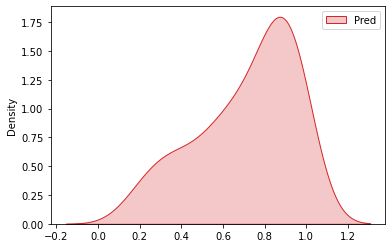

In [118]:
sns.kdeplot(pred, color='tab:red', label='Pred', shade=True)
plt.legend()
plt.show()

## 予測値の提出

In [198]:
df_test = pd.read_csv('Data/CreatedData/submission_2021.csv')

In [199]:
df_test

,ID,Season,HTeamID,RTeamID,is_tourney,Hwins_top25,Rwins_top25,Hconf,home,Rconf,...,tourny20plus_Diff,FG_Diff,FGopponent_Diff,FG3_Diff,FG3opponent_Diff,FT_Diff,wins_Diff,wins_last_Diff,FG_last_Diff,FG3_last_Diff
0,2021_1101_1104,2021,1104.0,1101.0,1,3,0,SEC,alabama,Slnd,...,0,-0.019896,0.002549,-0.025563,-0.008333,0.012579,-0.014389,0.000000,-0.030001,-0.046070
1,2021_1101_1111,2021,1101.0,1111.0,1,0,0,Slnd,abilene christian,SB,...,0,0.038060,-0.027891,0.046011,-0.032058,-0.005991,0.169311,0.000000,0.069469,0.008655
2,2021_1101_1116,2021,1116.0,1101.0,1,1,0,SEC,arkansas,Slnd,...,0,-0.003428,0.008876,-0.038188,0.014517,0.031490,-0.022357,-0.133531,0.002689,-0.037527
3,2021_1101_1124,2021,1124.0,1101.0,1,4,0,B12,baylor,Slnd,...,0,0.022892,0.020675,0.023477,0.035889,0.007880,0.048412,-0.105361,0.009995,0.010933
4,2021_1101_1140,2021,1140.0,1101.0,1,1,0,WCC,byu,Slnd,...,0,0.012589,0.004506,-0.013468,0.033686,0.030891,-0.036862,-0.287682,-0.023368,-0.026696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,2021,1452.0,1457.0,1,3,0,B12,west virginia,BSth,...,1,-0.022235,0.003981,0.008652,-0.010106,0.016866,-0.161268,-0.470004,-0.060934,-0.026716
2274,2021_1452_1458,2021,1452.0,1458.0,1,3,1,B12,west virginia,B10,...,0,0.005458,0.010964,-0.005064,-0.024448,-0.039554,0.049480,0.000000,-0.012253,-0.048916
2275,2021_1455_1457,2021,1455.0,1457.0,1,1,0,Amer,wichita st.,BSth,...,0,-0.038984,-0.014396,-0.004665,-0.008964,0.006070,-0.120025,-0.133531,-0.051596,0.023740
2276,2021_1455_1458,2021,1458.0,1455.0,1,1,1,B10,wisconsin,Amer,...,1,0.011291,0.007413,0.018381,0.023306,0.050350,-0.090723,-0.336472,0.002915,-0.001540


In [175]:
#KenPom
features = [
    'adjem_Diff', 
    'adjo_Diff',
    'adjd_Diff',
    'luck_Diff', 
    'sche_Diff',
    'TOmargin_Diff',
    'PointMargin_Diff', 
    'FG3_Diff',
    'FT_Diff', 
    'wins_Diff', 
    'tourny20plus_Diff', 
]

In [16]:
#2017-2019
feats_last = [#'Round',
              'FT_Diff','PointMargin_Diff','TOmargin_Diff','tourny20plus_Diff', 
              'adjem_Diff','adjt_Diff','luck_Diff','sche_Diff']

In [201]:
#ループを回して予測を行う

df_test = pd.read_csv('Data/CreatedData/submission_2015_2019.csv')
#df_test = pd.read_csv('Data/CreatedData/submission_2021.csv')
def make_submission(seasons, features):
    df_pred = pd.DataFrame()
    losses = []
    preds = np.array([])
    for season in seasons:
        data = all_games_df[all_games_df['is_tourney']==1]
        print(season)
        train_data = data[data['Season']<season]
        X_train = train_data[features]
        y_train = train_data['Hwin'].values

        val_data = data[data['Season']==season]
        X_val = val_data[features]
        y_val = val_data['Hwin'].values

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        model = LogisticRegression()
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_val)[:, 1]
        preds = np.concatenate([preds, pred], axis=0)
        print(log_loss(y_val, pred))
        print('--------------------------')
        losses.append(log_loss(y_val, pred))

        test_data = df_test[df_test['Season']==season]
        X_test = test_data[features]
        X_test = scaler.transform(X_test)
        df_pred = pd.concat([df_pred, 
                             pd.DataFrame(model.predict_proba(X_test)[:, 1]).rename(columns={0:'Pred'})], 
                            axis=0).reset_index(drop=True)
    print('\nAVG:{}'.format(np.array(losses).mean()))
    return df_pred

In [176]:
#ループを回して予測を行う

#df_test = pd.read_csv('Data/CreatedData/submission_2015_2019.csv')
df_test = pd.read_csv('Data/CreatedData/submission_2021.csv')
def make_final_submission(season, features):
    df_pred = pd.DataFrame()
    
    data = all_games_df[all_games_df['is_tourney']==1]
    train_data = data[data['Season']<season]
    X_train = train_data[features]
    y_train = train_data['Hwin'].values

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    test_data = df_test[df_test['Season']==season]
    X_test = test_data[features]
    X_test = scaler.transform(X_test)
    df_pred = pd.concat([df_pred, 
                         pd.DataFrame(model.predict_proba(X_test)[:, 1]).rename(columns={0:'Pred'})], 
                        axis=0).reset_index(drop=True)

    return df_pred

In [148]:
df_pred = make_submission(seasons=[2015,2016,2017,2018,2019], features=feats_last)

2015
0.48543980777895224
--------------------------
2016
0.4909256649628953
--------------------------
2017
0.4802821071142349
--------------------------
2018
0.5615547918396805
--------------------------
2019
0.4503426288383445
--------------------------

AVG:0.4937090001068215


In [202]:
#Leaky
df_pred = make_submission(seasons=[2015,2016,2017,2018,2019], features=feats_last)

2015
0.4585321406931903
--------------------------
2016
0.4614267665089229
--------------------------
2017
0.3933897237750719
--------------------------
2018
0.46051024356689435
--------------------------
2019
0.35357720995773917
--------------------------

AVG:0.42548721690036373


In [203]:
#最終予測値の作成
df_test = pd.read_csv('Data/CreatedData/submission_2021.csv')
df_pred = make_final_submission(2021, features=features)

In [171]:
#最終予測値の作成
df_pred = make_final_submission(2017, features=feats_last)

In [204]:
submission = pd.concat([df_test, df_pred], axis=1)
#小さな番号の勝率を予測するように変形する
submission.loc[submission['HTeamID']>submission['RTeamID'], 'Pred'] = 1 - submission.loc[submission['HTeamID']>submission['RTeamID'], 'Pred']

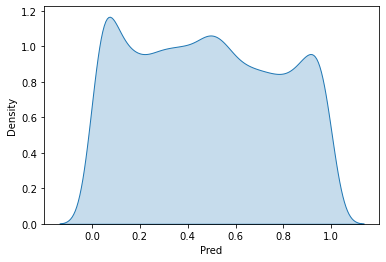

In [150]:
sns.kdeplot(submission['Pred'], shade=True)
plt.show()

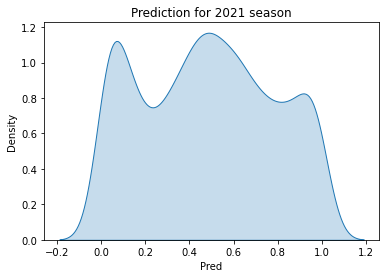

In [160]:
sns.kdeplot(submission['Pred'], shade=True)
plt.title('Prediction for 2021 season')
plt.show()

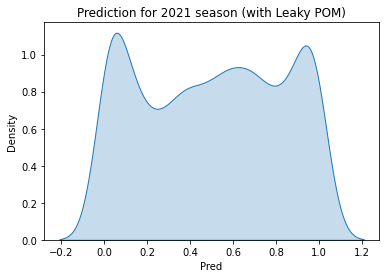

In [205]:
sns.kdeplot(submission['Pred'], shade=True)
plt.title('Prediction for 2021 season (with Leaky POM)')
plt.show()

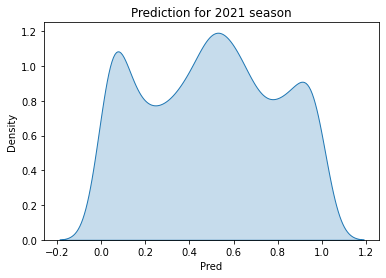

In [179]:
sns.kdeplot(submission['Pred'], shade=True)
plt.title('Prediction for 2021 season')
plt.show()

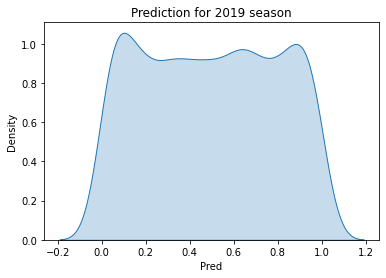

In [170]:
sns.kdeplot(submission['Pred'], shade=True)
plt.title('Prediction for 2019 season')
plt.show()

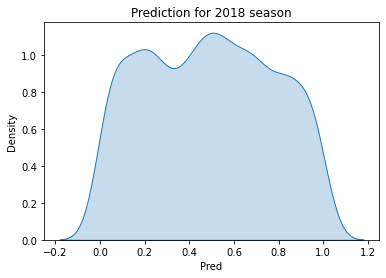

In [167]:
sns.kdeplot(submission['Pred'], shade=True)
plt.title('Prediction for 2018 season')
plt.show()

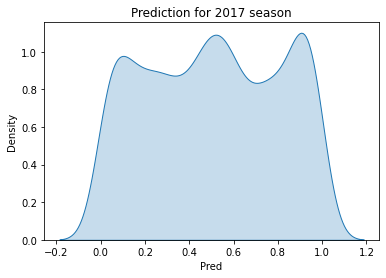

In [174]:
sns.kdeplot(submission['Pred'], shade=True)
plt.title('Prediction for 2017 season')
plt.show()

In [206]:
submission = submission[['ID', 'Pred']]

In [207]:
#Export to submit to Kaggle
submission.to_csv('Data/SubmitData/leakypom.csv', index=False)

## Neural Network

In [284]:
def prepare_data_nn(season, target_feat='Awins', only_tour=False):
    if only_tour:
        data = all_games_df[all_games_df['is_tourney']==1]
        train_data = data[data['Season']<season]
        val_data = data[data['Season']==season]
        
    else:
        data = all_games_df[~(all_games_df['Season'].isin([season]) & (all_games_df['is_tourney']==1))]
        train_data = data[data['Season']<=season]
        val_data = all_games_df[all_games_df['Season'].isin([season])]
        val_data = val_data[val_data['is_tourney']==1]
    
    X_train = train_data[features].astype('float32')
    y_train = train_data[target_feat].values.astype('float32')
    X_val = val_data[features].astype('float32')
    y_val = val_data[target_feat].values.astype('float32')
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, y_train, X_val, y_val

In [324]:
X_train, y_train, X_val, y_val = prepare_data_nn(2015, ['line','lineavg'], only_tour=True)

In [217]:
X_train, y_train, X_val, y_val  = prepare_data_nn(2014, 'Hwin', only_tour=True)

In [72]:
from keras.layers import Embedding, Flatten, Concatenate, Reshape
from keras import regularizers
model.add(Dense(64, input_dim=64,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
K.clear_session()

num_feats = X_train.shape[1]

inputs = Input(num_feats,)
# loc_inputs = Input(1,) #Home, Away, Nutoral


x = Dense(8, 'relu', kernel_regularizer=legularizers)(inputs)
x = Dense(5, 'relu')(x)
x = Dense(3, 'relu')(x)
out = Dense(1, 'sigmoid')(x)

#model = Model(inputs=[inputs, loc_inputs, round_inputs, teamstyle_inputs], outputs=out)
model = Model(inputs=inputs, outputs=out)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam)

In [222]:
#勝率予測モデル

from keras.layers import Embedding, Flatten, Concatenate, Reshape
from keras import regularizers
#kernel_regularizer = regularizers.l2(0.01)
kernel_regularizer = None

K.clear_session()

num_feats = X_train.shape[1]

inputs = Input(num_feats,)
# loc_inputs = Input(1,) #Home, Away, Nutoral


x = Dense(8, 'relu', kernel_regularizer=kernel_regularizer)(inputs)
x = Dense(5, 'relu', kernel_regularizer=kernel_regularizer)(x)
x = Dense(3, 'relu', kernel_regularizer=kernel_regularizer)(x)
out = Dense(1, 'sigmoid')(x)

#model = Model(inputs=[inputs, loc_inputs, round_inputs, teamstyle_inputs], outputs=out)
model = Model(inputs=inputs, outputs=out)
adam = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam)

In [219]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 160       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________


In [223]:
history = model.fit(X_train, y_train, 
          batch_size=32, epochs=100, 
          validation_data=(X_val, y_val), verbose=True)

Epoch 1/100
19/19 [==============================] - 0s 5ms/step - loss: 0.6628 - val_loss: 0.6692
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6491 - val_loss: 0.6620
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6348 - val_loss: 0.6534
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6202 - val_loss: 0.6448
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6064 - val_loss: 0.6372
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5956 - val_loss: 0.6313
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5858 - val_loss: 0.6284
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5792 - val_loss: 0.6261
Epoch 9/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5736 - val_loss: 0.6246
Epoch 10/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5689 - val_loss: 0.6221
Epoch 11/

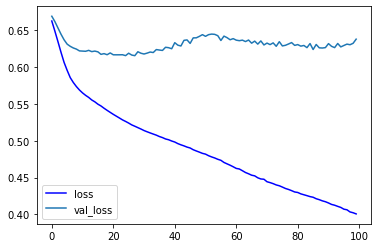

In [224]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses['loss'], color='b', label='loss')
plt.plot(losses['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [30]:
pred_val = pd.DataFrame(model.predict(scaled_X_valid))

#サンプルとして2015〜2019シーズンにおける正解値を作成
val_years = [2013,2014]
tmp_val = all_games_df[all_games_df['Season'].isin(val_years)]
tmp_val = tmp_val[tmp_val['is_tourney']==1].reset_index(drop=True)

#Note: I'm predicting home (lower seed) win probability. 
#Need to convert to be consistent with output file (lower team ID)
pred_val = pd.merge(tmp_val, pred_val, left_index=True, right_index=True)

In [31]:
print('Total')
print(log_loss(pred_val['Hwin'], pred_val[0]))
#2013
print('------------------------------')
print('2013')
print(log_loss(pred_val[pred_val['Season']==2013]['Hwin'], pred_val[pred_val['Season']==2013][0]))
#2014
print('------------------------------')
print('2014')
print(log_loss(pred_val[pred_val['Season']==2014]['Hwin'], pred_val[pred_val['Season']==2014][0]))

Total
0.608550520392046
------------------------------
2013
0.6062142647569999
------------------------------
2014
0.6109621391120937


## SHAPによる特徴量重要度

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gc
import shap

In [296]:
# load JS visualization code to notebook
shap.initjs()

In [23]:
all_games_df.columns

Index(['Season', 'date', 'is_tourney', 'home', 'Round', 'HTeamID', 'hscore',
       'road', 'RTeamID', 'rscore', 'line', 'lineavg', 'Hwin', 'Hconf',
       'Rconf', 'Seed_Diff', 'adjem_Diff', 'adjo_Diff', 'adjd_Diff',
       'adjt_Diff', 'luck_Diff', 'sche_Diff', 'RankPOM_Diff', 'TOmargin_Diff',
       'PointMargin_Diff', 'FG_Diff', 'FGopponent_Diff', 'FG3_Diff',
       'FG3opponent_Diff', 'FT_Diff', 'wins_Diff', 'wins_top25_Diff',
       'tourny20plus_Diff', 'TopConf_Diff', 'wins_last_Diff',
       'TOmargin_last_Diff', 'PointMargin_last_Diff', 'FG_last_Diff',
       'FGopponent_last_Diff', 'FG3_last_Diff', 'FG3opponent_last_Diff',
       'FT_last_Diff', 'wins_top25_last_Diff'],
      dtype='object')

In [70]:
#KenPom
features = [
#    'Round',
#    'line', 
#    'lineavg', 
#    'Seed_Diff', 
    'adjem_Diff', 
    'adjo_Diff',
    'adjd_Diff',
#    'adjt_Diff', 
    'luck_Diff', 
    'sche_Diff',
#    'ORmargin_Diff',
#    'DRmargin_Diff',
#    'RankPOM_Diff', 
    'TOmargin_Diff',
   'PointMargin_Diff', 
#    'FG_Diff', 
#    'FGopponent_Diff', 
    'FG3_Diff',
#    'FG3opponent_Diff', 
    'FT_Diff', 
    'wins_Diff', 
#    'wins_top25_Diff',
    'tourny20plus_Diff', 
#    'TopConf_Diff', 
#    'wins_last_Diff',
#    'TOmargin_last_Diff', 
#    'PointMargin_last_Diff', 
#    'FG_last_Diff',
#    'FGopponent_last_Diff', 
#    'FG3_last_Diff', 
#    'FG3opponent_last_Diff',
#    'FT_last_Diff', 
#    'wins_top25_last_Diff'
]

In [63]:
xgb_params= {
        "objective": "binary:logistic",
        #"objective":"reg:squarederror",
        "max_depth": 2,
        "learning_rate": 0.01,
        "colsample_bytree": 0.8,
        "subsample": 0.9,
        #"reg_alpha" : 0,
        #"n_estimators":400,
        "min_child_weight": 30,
        "n_jobs": 2,
        "seed": 2001,
        'tree_method': "gpu_hist",
        "gpu_id": 0,
        'predictor': 'gpu_predictor'
    }

In [64]:
def prepare_data_xgb(year):
    data = all_games_df[~(all_games_df['Season'].isin([year]) & (all_games_df['is_tourney']==1))]
    data = data[data['Season']<=year]
    return data

def prepare_data_onlytour(season, target_feat):
    data = all_games_df[all_games_df['is_tourney']==1]
    train_data = data[data['Season']<season]
    val_data = data[data['Season'].isin([season])]
    
    X_train = train_data[features].reset_index(drop=True)
    y_train = train_data[target_feat].reset_index(drop=True).values
    X_val = val_data[features].reset_index(drop=True)
    y_val = val_data[target_feat].reset_index(drop=True).values
    
    return X_train, y_train, X_val, y_val

In [65]:
#年度を入力するとその年を予測してくれる関数
def pred_year_xgb(year=2019, target_col='Awins', onlytour=False, regression=False):
    if onlytour:
        X_train, y_train, X_val, y_val = prepare_data_onlytour(year, target_col)
    
    else:
        train_data = prepare_data_xgb(year)
        X_train = train_data[features].reset_index(drop=True)
        y_train = train_data[target_col].reset_index(drop=True).values

        val_data = all_games_df[all_games_df['Season'].isin([year])]
        val_data = val_data[val_data['is_tourney']==1]
        X_val = val_data[features].reset_index(drop=True)
        y_val = val_data[target_col].reset_index(drop=True).values
    
    if regression:
        xgb_params['objective'] = "reg:squarederror"
        X_train = xgb.DMatrix(X_train,label=y_train)
        X_valid = xgb.DMatrix(X_val,label=y_val)
        model = xgb.train(xgb_params, X_train, 400)
        pred = pd.DataFrame(model.predict(X_valid)).rename(columns={0:'pred'})
        print('RMSE:{}, MAE:{}'.format(np.sqrt(mean_squared_error(y_val, pred)),mean_absolute_error(y_val, pred)))
        shap_preds = model.predict(X_valid, pred_contribs=True)
        shap.summary_plot(shap_preds[:,:-1], X_val)
        shap.summary_plot(shap_preds[:,:-1], X_val, plot_type="bar")
        xgb.plot_importance(model)
        plt.show()
        
        return model, pred
        
    else:
        X_train = xgb.DMatrix(X_train, label=y_train)
        X_valid = xgb.DMatrix(X_val, label=y_val)
        model = xgb.train(xgb_params, X_train, 400)
        pred = pd.DataFrame(model.predict(X_valid)).rename(columns={0:'pred'})
        print('loss:{:.3f}'.format(log_loss(y_val, pred)))
        shap_preds = model.predict(X_valid, pred_contribs=True)
        shap.summary_plot(shap_preds[:,:-1], X_val)
        shap.summary_plot(shap_preds[:,:-1], X_val, plot_type="bar")
        xgb.plot_importance(model)
        plt.show()
        
        return model, pred

[07:58:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
loss:0.494


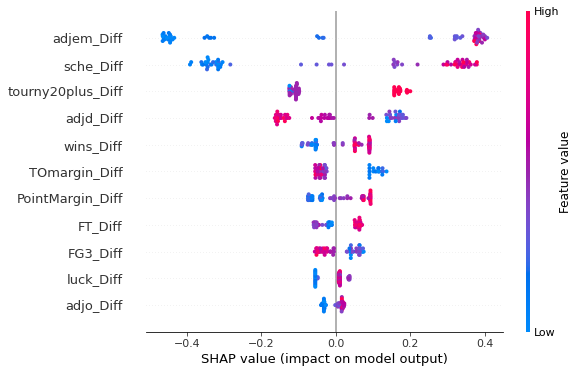

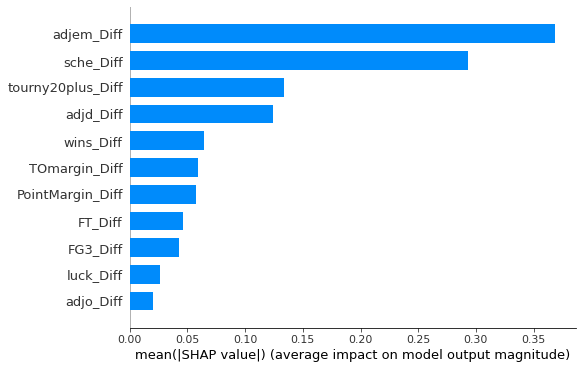

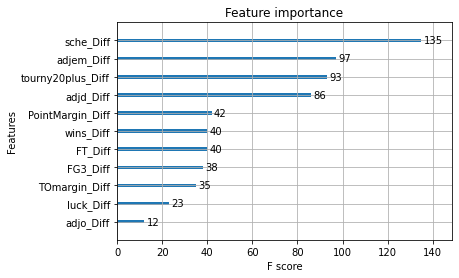

In [75]:
model, pred = pred_year_xgb(2015, target_col='Hwin', onlytour=True, regression=False)

In [80]:
#y = y_train
#s = df['Season']
X_xgbtrain = xgb.DMatrix(X_train[features], label=y_train)

In [81]:
X_xgbvalid = xgb.DMatrix(X_valid[features], label=y_valid)

In [65]:
train_oof = np.zeros((X.shape[0],))
test_preds = 0
train_oof.shape

(35721,)

In [90]:
X_valid[features]

,is_tourney,HRankPOM,RRankPOM,Hwins_top25,Rwins_top25,HPointMargin,RPointMargin,HFG,RFG,HFG3,...,Hluck,Radjo,Radjd,Rluck,Htourny20plus,Rtourny20plus,HBig4Conf,RBig4Conf,HSeed,RSeed
0,1.0,11.0,102.0,4.0,1.0,11.437500,6.290323,0.481347,0.467053,0.364361,...,-0.011,110.4,103.1,0.030,1.0,0.0,1.0,0.0,4.0,13.0
1,1.0,28.0,45.0,0.0,4.0,7.060606,2.500000,0.439355,0.416215,0.358496,...,0.039,105.4,90.0,0.022,1.0,1.0,1.0,0.0,8.0,9.0
2,1.0,8.0,183.0,3.0,0.0,13.911765,0.705882,0.481583,0.431984,0.360473,...,0.019,100.1,101.8,0.039,1.0,0.0,1.0,0.0,1.0,16.0
3,1.0,22.0,32.0,1.0,0.0,11.562500,13.454545,0.472601,0.464981,0.373654,...,0.040,106.9,89.1,0.056,0.0,0.0,0.0,0.0,11.0,11.0
4,1.0,9.0,34.0,6.0,3.0,9.617647,10.617647,0.424545,0.441736,0.333586,...,-0.026,111.8,93.6,0.002,1.0,0.0,1.0,1.0,5.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,1.0,18.0,65.0,1.0,0.0,11.058824,5.727273,0.491634,0.442048,0.397603,...,-0.015,105.3,96.0,-0.025,1.0,0.0,0.0,0.0,4.0,13.0
122,1.0,2.0,34.0,1.0,1.0,21.147059,8.258065,0.474107,0.445624,0.356702,...,-0.044,104.6,91.2,0.024,1.0,0.0,0.0,0.0,4.0,5.0
123,1.0,11.0,27.0,1.0,2.0,9.125000,11.906250,0.445327,0.466170,0.333906,...,-0.097,120.1,102.5,-0.114,0.0,0.0,1.0,1.0,11.0,11.0
124,1.0,13.0,97.0,4.0,0.0,8.969697,5.312500,0.457373,0.498272,0.375883,...,0.020,103.2,97.3,-0.032,1.0,0.0,1.0,0.0,2.0,15.0


In [314]:
NUM_FOLDS = 10
kf = GroupKFold(n_splits=NUM_FOLDS)

for f, (train_idx, val_idx) in tqdm(enumerate(kf.split(X, y, s))):
        print(f'Fold {f}')
        train_df, val_df = X.iloc[train_idx], X.iloc[val_idx]
        train_target, val_target = y.iloc[train_idx], y.iloc[val_idx]
        
        train_df = xgb.DMatrix(train_df, label=train_target)
        val_df = xgb.DMatrix(val_df, label=val_target)
        model =  xgb.train(xgb_params, train_df, 400)
        temp_oof = model.predict(val_df)
        #temp_test = model.predict(test)

        train_oof[val_idx] = temp_oof
        #test_preds += temp_test/NUM_FOLDS
        
        print(log_loss(val_target, temp_oof))

0it [00:00, ?it/s]

Fold 0
[10:53:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1it [00:00,  4.39it/s]

0.4990943502208204
Fold 1
[10:53:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2it [00:00,  4.45it/s]

0.5301909523781474
Fold 2
[10:53:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


3it [00:00,  4.52it/s]

0.5841308308637324
Fold 3
[10:53:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


4it [00:00,  4.60it/s]

0.5515086746966565
Fold 4
[10:53:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


5it [00:01,  4.68it/s]

0.5682548287658746
Fold 5
[10:53:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


6it [00:01,  4.74it/s]

0.6210022197879908
Fold 6
[10:53:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


7it [00:01,  4.80it/s]

0.5239044655281216
Fold 7
[10:53:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


9it [00:01,  4.87it/s]

0.5753496266456682
Fold 8
[10:53:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5378501498654708


10it [00:02,  4.89it/s]

Fold 9
[10:53:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5182265787152573


10it [00:02,  4.79it/s]


In [104]:
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)

In [89]:
%%time
shap_preds = xgbmodel.predict(X_xgbvalid, pred_contribs=True)

CPU times: user 1.79 ms, sys: 8.75 ms, total: 10.5 ms
Wall time: 11.5 ms


In [94]:
%%time
shap_interactions = xgbmodel.predict(X_xgbvalid, pred_interactions=True)

CPU times: user 9.18 ms, sys: 8.25 ms, total: 17.4 ms
Wall time: 17.5 ms


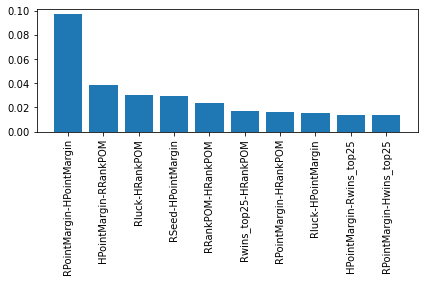

In [95]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))
    plt.bar(interaction_features[:k], interaction_values[:k])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_top_k_interactions(X_valid[features].columns, shap_interactions, 10)

Random forest

In [49]:
clf = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_leaf=3)
clf.fit(X_train, y_train)
rf_prob = pd.DataFrame(clf.predict_proba(X_valid))
LogLoss(rf_prob[1], y_valid)

0.5807195719900436

In [179]:
clf = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_leaf=3)
clf.fit(X_train, y_train)
rf_prob = pd.DataFrame(clf.predict_proba(X_val))
log_loss(y_val, rf_prob[1])

0.512370840352539

In [50]:
avg = (rf_prob[1]+xgb_valid_prob+nn_pred)/3

In [51]:
LogLoss(avg, y_valid)

0.5196065131373279

## ロジスティック回帰のハイパーパラメータ

In [414]:
import optuna

In [752]:
#'liblinear'
def create_model(penalty, C, l1_ratio=None):
    model = LogisticRegression(penalty=penalty, C=C, solver='saga', l1_ratio=l1_ratio)
    return model

In [770]:
X_train, y_train, X_val, y_val = prepare_data_nn([2019,2018,2017,2016,2015], 
                                                 'Hwin', only_tour=True)

In [786]:
def objective(trial):    
    penalty = trial.suggest_categorical("penalty", ["l1", 'l2', 'elasticnet',])
    C = trial.suggest_int("C", -3, 3)
    C = float(10**C)
    #C = trial.suggest_float("C", 0.001, 100000, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    
    if penalty=='l1':
        model = create_model(penalty, C, l1_ratio)
    elif penalty=='elasticnet':
        model = create_model(penalty, C, l1_ratio)
    else:
        model = create_model(penalty, C)

    model = create_model('l2', C)
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_val)[:,1]
    res = log_loss(y_val, pred)
    
    return res

In [788]:
study_name = 'logit-study'  
study = optuna.create_study(study_name=study_name, 
                            storage='sqlite:///db/logit.db', 
                            load_if_exists=True)

[I 2021-03-12 14:30:11,063] A new study created in RDB with name: logit-study


In [787]:
optuna.delete_study(study_name=study_name, storage='sqlite:///db/logit.db')

In [789]:
study = optuna.create_study()
study.optimize(objective, n_trials=100, )

[I 2021-03-12 14:30:12,867] A new study created in memory with name: no-name-27ac9517-b7e6-4815-a627-3347faaf56a1
[I 2021-03-12 14:30:12,873] Trial 0 finished with value: 0.5180837203863884 and parameters: {'penalty': 'l2', 'C': 3, 'l1_ratio': 0.21749420818447707}. Best is trial 0 with value: 0.5180837203863884.
[I 2021-03-12 14:30:12,878] Trial 1 finished with value: 0.5767197823686542 and parameters: {'penalty': 'elasticnet', 'C': -3, 'l1_ratio': 0.4125540604114706}. Best is trial 0 with value: 0.5180837203863884.
[I 2021-03-12 14:30:12,882] Trial 2 finished with value: 0.5767194283872933 and parameters: {'penalty': 'l1', 'C': -3, 'l1_ratio': 0.11197080775941393}. Best is trial 0 with value: 0.5180837203863884.
[I 2021-03-12 14:30:12,886] Trial 3 finished with value: 0.5767198206794947 and parameters: {'penalty': 'l2', 'C': -3, 'l1_ratio': 0.39914849910263317}. Best is trial 0 with value: 0.5180837203863884.
[I 2021-03-12 14:30:12,890] Trial 4 finished with value: 0.518082271251276 a

In [790]:
study.best_params

{'penalty': 'l1', 'C': 0, 'l1_ratio': 0.9403177380656907}

In [791]:
mncaa_study = study.trials_dataframe()

In [792]:
mncaa_study.sort_values(by='value')

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_penalty,state
32,32,0.517968,2021-03-12 14:30:13.136841,2021-03-12 14:30:13.146094,0 days 00:00:00.009253,0,0.940318,l1,COMPLETE
10,10,0.517969,2021-03-12 14:30:12.914340,2021-03-12 14:30:12.922982,0 days 00:00:00.008642,0,0.962923,l1,COMPLETE
54,54,0.517969,2021-03-12 14:30:13.364013,2021-03-12 14:30:13.374098,0 days 00:00:00.010085,0,0.906086,l1,COMPLETE
21,21,0.517970,2021-03-12 14:30:13.024219,2021-03-12 14:30:13.032873,0 days 00:00:00.008654,0,0.991391,l1,COMPLETE
74,74,0.517970,2021-03-12 14:30:13.577242,2021-03-12 14:30:13.587210,0 days 00:00:00.009968,0,0.976047,l1,COMPLETE
...,...,...,...,...,...,...,...,...,...
24,24,0.531021,2021-03-12 14:30:13.054265,2021-03-12 14:30:13.063661,0 days 00:00:00.009396,-2,0.827366,l1,COMPLETE
5,5,0.576719,2021-03-12 14:30:12.891225,2021-03-12 14:30:12.894788,0 days 00:00:00.003563,-3,0.312047,l1,COMPLETE
2,2,0.576719,2021-03-12 14:30:12.879287,2021-03-12 14:30:12.882485,0 days 00:00:00.003198,-3,0.111971,l1,COMPLETE
1,1,0.576720,2021-03-12 14:30:12.875337,2021-03-12 14:30:12.878647,0 days 00:00:00.003310,-3,0.412554,elasticnet,COMPLETE


In [305]:
mncaa_study.to_csv('./hyper_params.csv', index=False)

- optunaで特徴量選択

In [405]:
def prepare_data_optuna(season, features, target_feat='Hwin', only_tour=True,):
    if only_tour:
        data = all_games_df[all_games_df['is_tourney']==1]
        train_data = data[data['Season']<min(season)]
        val_data = data[data['Season'].isin(season)]
        
    else:
        data = all_games_df[~((all_games_df['Season'].isin(season)) & (all_games_df['is_tourney']==1))]
        train_data = data[data['Season']<=min(season)]
        val_data = all_games_df[all_games_df['Season'].isin(season)]
        val_data = val_data[val_data['is_tourney']==1]
    
    X_train = train_data[features].astype('float32')
    y_train = train_data[target_feat].values.astype('float32')
    X_val = val_data[features].astype('float32')
    y_val = val_data[target_feat].values.astype('float32')

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, y_train, X_val, y_val

In [401]:
#KenPom
features = [
#    'Round',
#    'line', 
#    'lineavg', 
#    'Seed_Diff', 
    'adjem_Diff', 
    'adjo_Diff',
    'adjd_Diff',
    'adjt_Diff', 
    'luck_Diff', 
    'sche_Diff',
#    'ORmargin_Diff',
#    'DRmargin_Diff',
#    'RankPOM_Diff', 
    'TOmargin_Diff',
    'PointMargin_Diff', 
#    'FG_Diff', 
#    'FGopponent_Diff', 
    'FG3_Diff',
#    'FG3opponent_Diff', 
    'FT_Diff', 
#    'wins_Diff', 
#    'wins_top25_Diff',
    'tourny20plus_Diff', 
#    'TopConf_Diff', 
#    'wins_last_Diff',
#    'TOmargin_last_Diff', 
#    'PointMargin_last_Diff', 
#    'FG_last_Diff',
#    'FGopponent_last_Diff', 
#    'FG3_last_Diff', 
#    'FG3opponent_last_Diff',
#    'FT_last_Diff', 
#    'wins_top25_last_Diff'
]

In [450]:
np.repeat(0.1, 10)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [513]:
#特徴量選択用
def objective(trial):    
    #seasons = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
    seasons = [2014,2016,2018] #簡単な年
    weights = [0.2,0.2,0.6]
    #weights = np.repeat(0.1, 3)
    feats = []
    errs = 0
    use_Round = trial.suggest_int('Round', 0, 1)
    use_FG = trial.suggest_int("FG", 0, 1)
    use_FG3 = trial.suggest_int('FG3', 0, 1)
    use_FT = trial.suggest_int('FT', 0, 1)
    use_Seed = trial.suggest_int('Seed', 0, 1)
    #use_OR = trial.suggest_int('OR', 0, 1)
    #use_DR = trial.suggest_int('DR', 0, 1)
    use_Point = trial.suggest_int('Point', 0, 1)
    use_winrate = trial.suggest_int('winrate', 0, 1)
    use_winrateLast = trial.suggest_int('winrateLast', 0, 1)
    use_TO = trial.suggest_int('TO', 0, 1)
    #use_FGopp = trial.suggest_int('FGopp', 0, 1)
    #use_FG3opp = trial.suggest_int('FG3opp', 0, 1)
    use_FGLast = trial.suggest_int('FGLast', 0, 1)
    use_FG3Last = trial.suggest_int('FG3Last', 0, 1)
    use_FTLast = trial.suggest_int('FTLast', 0, 1)
    use_tour20 = trial.suggest_int('tour20plus', 0, 1)
    use_adjem = trial.suggest_int('adjem', 0, 1)
    use_adjo = trial.suggest_int('adjo', 0, 1)
    use_adjd = trial.suggest_int('adjd', 0, 1)
    use_adjt = trial.suggest_int('adjt', 0, 1)
    use_luck = trial.suggest_int('luck', 0, 1)
    use_sche = trial.suggest_int('sche', 0, 1)
    
    if use_adjem:
        feats += ['adjem_Diff']
    if use_adjo:
        feats += ['adjo_Diff']
    if use_adjd:
        feats += ['adjd_Diff']
    if use_adjt:
        feats += ['adjt_Diff']
    if use_luck:
        feats += ['luck_Diff']
    if use_sche:
        feats += ['sche_Diff']
    if use_Round:
        feats += ['Round']
    if use_Point:
        feats += ['PointMargin_Diff']
    if use_FG:
        feats += ['FG_Diff']
    if use_FG3:
        feats += ['FG3_Diff']
    if use_FT:
        feats += ['FT_Diff']
    if use_Seed:
        feats += ['Seed_Diff']
#     if use_OR:
#         feats += ['ORmargin_Diff']
#     if use_DR:
#         feats += ['DRmargin_Diff']
    if use_winrate:
        feats += ['wins_Diff']
    if use_winrateLast:
        feats += ['wins_last_Diff']
    if use_TO:
        feats += ['TOmargin_Diff']
#     if use_FGopp:
#         feats += ['FGopponent_Diff']
#     if use_FG3opp:
#         feats += ['FG3opponent_Diff']
    if use_FGLast:
        feats += ['FG_last_Diff']
    if use_FG3Last:
        feats += ['FG3_last_Diff']
    if use_FTLast:
        feats += ['FT_last_Diff']
    if use_tour20:
        feats += ['tourny20plus_Diff']
    
    if len(feats)==0:
        feats += ['TOmargin_Diff']
        
    for i in range(len(seasons)):
        X_train, y_train, X_val, y_val = prepare_data_optuna([seasons[i]],features=feats,)
        
        model = LogisticRegression(C=1.0)
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_val)[:, 1]
        errs += log_loss(y_val, pred)*weights[i]
    
    #err = errs / len(seasons)
    
    return errs

In [453]:
study_name = 'feature-study'  
study = optuna.create_study(study_name=study_name, 
                            storage='sqlite:///db/feats.db', 
                            load_if_exists=True)

[I 2021-03-14 16:33:49,986] A new study created in RDB with name: feature-study


In [498]:
study_name = 'easyyear-study'  
study = optuna.create_study(study_name=study_name, 
                            storage='sqlite:///db/easy.db', 
                            load_if_exists=True)

[I 2021-03-14 18:32:48,131] A new study created in RDB with name: easyyear-study


In [514]:
study_name = 'hardyear-study'  
study = optuna.create_study(study_name=study_name, 
                            storage='sqlite:///db/hard.db', 
                            load_if_exists=True)

[I 2021-03-14 19:34:46,751] A new study created in RDB with name: hardyear-study


In [452]:
optuna.delete_study(study_name=study_name, storage='sqlite:///db/feats.db')

In [515]:
study = optuna.create_study()
study.optimize(objective, n_trials=3500, )

[I 2021-03-14 19:34:53,267] A new study created in memory with name: no-name-3275dd16-7732-4ed7-aa12-dd7fccf67575
[I 2021-03-14 19:34:53,303] Trial 0 finished with value: 0.5709946153619896 and parameters: {'Round': 0, 'FG': 0, 'FG3': 1, 'FT': 0, 'Seed': 1, 'Point': 0, 'winrate': 0, 'winrateLast': 1, 'TO': 1, 'FGLast': 1, 'FG3Last': 1, 'FTLast': 0, 'tour20plus': 1, 'adjem': 0, 'adjo': 1, 'adjd': 0, 'adjt': 0, 'luck': 1, 'sche': 1}. Best is trial 0 with value: 0.5709946153619896.
[I 2021-03-14 19:34:53,335] Trial 1 finished with value: 0.5811112094158444 and parameters: {'Round': 0, 'FG': 1, 'FG3': 0, 'FT': 0, 'Seed': 1, 'Point': 0, 'winrate': 1, 'winrateLast': 1, 'TO': 1, 'FGLast': 0, 'FG3Last': 1, 'FTLast': 0, 'tour20plus': 1, 'adjem': 0, 'adjo': 0, 'adjd': 0, 'adjt': 0, 'luck': 1, 'sche': 0}. Best is trial 0 with value: 0.5709946153619896.
[I 2021-03-14 19:34:53,367] Trial 2 finished with value: 0.5629262161703286 and parameters: {'Round': 0, 'FG': 0, 'FG3': 0, 'FT': 0, 'Seed': 0, 'P

In [516]:
study.best_params

{'Round': 1,
 'FG': 0,
 'FG3': 0,
 'FT': 1,
 'Seed': 1,
 'Point': 1,
 'winrate': 1,
 'winrateLast': 0,
 'TO': 1,
 'FGLast': 1,
 'FG3Last': 0,
 'FTLast': 0,
 'tour20plus': 1,
 'adjem': 1,
 'adjo': 1,
 'adjd': 1,
 'adjt': 0,
 'luck': 0,
 'sche': 1}

In [517]:
feat_study = study.trials_dataframe()

In [518]:
feat_study.sort_values(by='value').iloc[:10, :]

,number,value,datetime_start,datetime_complete,duration,params_FG,params_FG3,params_FG3Last,params_FGLast,params_FT,...,params_adjd,params_adjem,params_adjo,params_adjt,params_luck,params_sche,params_tour20plus,params_winrate,params_winrateLast,state
1749,1749,0.507581,2021-03-14 19:39:34.432606,2021-03-14 19:39:34.667682,0 days 00:00:00.235076,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,COMPLETE
2222,2222,0.507581,2021-03-14 19:41:34.039952,2021-03-14 19:41:34.297528,0 days 00:00:00.257576,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,COMPLETE
2223,2223,0.507581,2021-03-14 19:41:34.299445,2021-03-14 19:41:34.591830,0 days 00:00:00.292385,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,COMPLETE
2224,2224,0.507581,2021-03-14 19:41:34.593756,2021-03-14 19:41:34.861008,0 days 00:00:00.267252,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,COMPLETE
2225,2225,0.507581,2021-03-14 19:41:34.862560,2021-03-14 19:41:35.140271,0 days 00:00:00.277711,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,COMPLETE
2227,2227,0.507581,2021-03-14 19:41:35.450225,2021-03-14 19:41:35.726581,0 days 00:00:00.276356,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,COMPLETE
2228,2228,0.507581,2021-03-14 19:41:35.728266,2021-03-14 19:41:35.975449,0 days 00:00:00.247183,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,COMPLETE
2229,2229,0.507581,2021-03-14 19:41:35.977126,2021-03-14 19:41:36.256019,0 days 00:00:00.278893,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,COMPLETE
2230,2230,0.507581,2021-03-14 19:41:36.257582,2021-03-14 19:41:36.511190,0 days 00:00:00.253608,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,COMPLETE
2231,2231,0.507581,2021-03-14 19:41:36.512929,2021-03-14 19:41:36.765774,0 days 00:00:00.252845,0,0,0,1,1,...,1,1,1,0,0,1,1,1,0,COMPLETE


## レギュラーシーズンのデータからlineを予測する

In [28]:
spread_df = pd.read_csv('Data/spreads_all.csv')

In [261]:
all_games_df = pd.read_csv('Data/CreatedData/all_games_kenpom.csv')

In [29]:
null_line = all_games_df[(all_games_df['line'].isna())&(all_games_df['is_tourney']==1)].index
test = all_games_df.loc[null_line]

In [31]:
#NNで予測した値で補完
all_games_df.loc[null_line, 'line'] = 5.020337
all_games_df.fillna(all_games_df.mean(),inplace=True)

In [244]:
test

,Season,date,is_tourney,home,Round,HTeamID,hscore,road,RTeamID,rscore,...,FG_Diff,FGopponent_Diff,FG3_Diff,FG3opponent_Diff,FT_Diff,wins_Diff,wins_top25_Diff,wins_top5_Diff,tourny20plus_Diff,TopConf_Diff
6977,2006,03/17/2006,1.0,west virginia,1,1452.0,64.0,southern illinois,1356.0,46.0,...,0.032212,0.053025,0.007171,0.04904,0.055672,-0.054505,4,1,1,1


In [32]:
all_games_df.to_csv('Data/CreatedData/all_games_kenpom_withlast.csv', index=False)

In [223]:
features = [
#    'is_tourney',
# 'line',
# 'lineavg',
# 'Seed_Diff',
 'adjem_Diff','adjo_Diff', 
 'adjd_Diff', 'adjt_Diff', 
 'luck_Diff', 
'sche_Diff',
#'oppo_Diff', 'oppd_Diff',
 'RankPOM_Diff',
 'Score_Diff',
# 'OpponentScore_Diff',
# 'TOmargin_Diff',
 'PointMargin_Diff',
# 'FG_Diff',
# 'FGopponent_Diff',
# 'FG3_Diff',
# 'FG3opponent_Diff',
# 'FT_Diff',
 'wins_Diff',
# 'wins_top25_Diff',
# 'wins_top5_Diff',
 'tourny20plus_Diff',
# 'TopConf_Diff',
]

In [225]:
def prepare_data_line(season, target_feat='Awins', only_tour=False):
    if only_tour:
        data = all_games_df[all_games_df['is_tourney']==1]
        train_data = data[data['Season']<season]
        val_data = data[data['Season']==season]
        
    else:
        data = all_games_df[~(all_games_df['Season'].isin([season]) & (all_games_df['is_tourney']==1))]
        train_data = data[data['Season']<=season]
        val_data = all_games_df[all_games_df['Season'].isin([season])]
        val_data = val_data[val_data['is_tourney']==1]
    
    X_train = train_data[features].astype('float32')
    y_train = train_data[target_feat].values.astype('float32')
    X_val = val_data[features].astype('float32')
    y_val = val_data[target_feat].values.astype('float32')
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, y_train, X_val, y_val

In [245]:
X_train, y_train, X_val, y_val = prepare_data_line(2016, ['line','lineavg'], only_tour=True)

In [250]:
#欠損値をモデルで予測する
data = all_games_df[all_games_df['is_tourney']==1]
X_train = data[features]
y_train = data['line'].values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [235]:
model = ElasticNet(alpha=1, l1_ratio=0.5)
model.fit(X_train, y_train)
pred = model.predict(X_val)

RMSE = np.sqrt(mean_squared_error(y_val, pred))
MAE = mean_absolute_error(y_val, pred)
print('RMSE:{}'.format(RMSE))
print('MAE:{}'.format(MAE))

RMSE:2.411746025085449
MAE:1.8010222911834717


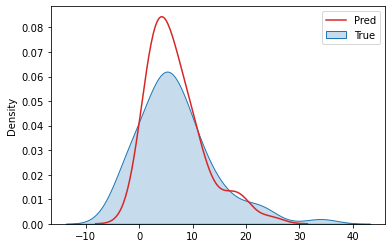

In [259]:
sns.kdeplot(pred[:, 0], color='tab:red', label='Pred')
sns.kdeplot(y_val[:,0], shade=True, label='True')
plt.legend()
plt.show()

In [258]:
#line予測モデル

from keras.layers import Embedding, Flatten, Concatenate, Reshape
from keras import regularizers
#kernel_regularizer = regularizers.l2(0.01)
kernel_regularizer = None

K.clear_session()

num_feats = X_train.shape[1]

inputs = Input(num_feats,)
# loc_inputs = Input(1,) #Home, Away, Nutoral


x = Dense(8, 'relu', kernel_regularizer=kernel_regularizer)(inputs)
x = Dense(5, 'relu', kernel_regularizer=kernel_regularizer)(x)
out = Dense(1, None, kernel_regularizer=kernel_regularizer)(x)

#model = Model(inputs=[inputs, loc_inputs, round_inputs, teamstyle_inputs], outputs=out)
model = Model(inputs=inputs, outputs=out)
adam = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=adam)

In [306]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 12        
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [259]:
history = model.fit(X_train, y_train, 
          batch_size=32, epochs=100, verbose=False,
         # validation_data=(X_val, y_val)
                   )

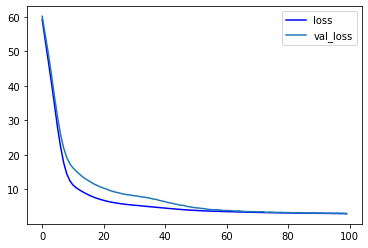

In [248]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses['loss'], color='b', label='loss')
plt.plot(losses['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [255]:
test = test[features]
test = scaler.transform(test)

In [260]:
model.predict(test)

array([[5.020337]], dtype=float32)

In [249]:
pred = model.predict(X_val)

RMSE = np.sqrt(mean_squared_error(y_val, pred))
MAE = mean_absolute_error(y_val, pred)
print('RMSE:{}'.format(RMSE))
print('MAE:{}'.format(MAE))

RMSE:1.693881869316101
MAE:1.3863067626953125


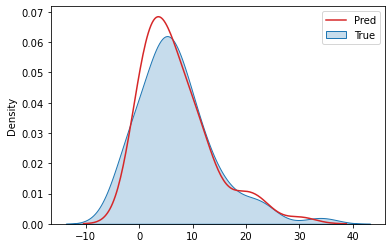

In [322]:
sns.kdeplot(pred[:, 0], color='tab:red', label='Pred')
sns.kdeplot(y_val[:,0], shade=True, label='True')
plt.legend()
plt.show()

## 各シーズンにおける特徴を見る

In [343]:
#Tourのコンパクトな結果から作成
tour_games =  compactResTour.merge(seeds_df, left_on=['Season','WTeamID'], right_on=['Season', 'TeamID'], 
                     how='left').drop('TeamID',axis=1).rename(columns={'Seed':'WSeed'})
tour_games = tour_games.merge(seeds_df, left_on=['Season','LTeamID'], right_on=['Season', 'TeamID'], 
                     how='left').drop('TeamID',axis=1).rename(columns={'Seed':'LSeed'})

tour_games['Hwin'] = 1.0

tour_games['Seed_Diff'] = tour_games['LSeed'] - tour_games['WSeed']
gkill_games = tour_games[tour_games['Seed_Diff']<0].reset_index(drop=True)

In [344]:
gkill_games = gkill_games[gkill_games['Season']>=2004]

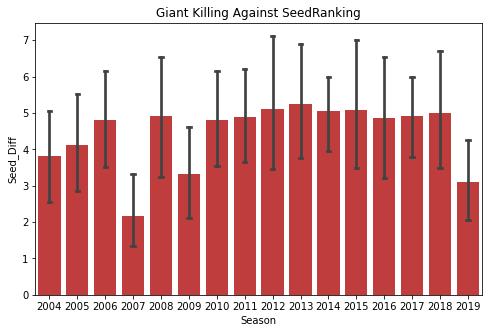

In [345]:
#シードの差が平均的に幾つ覆されたか
plt.figure(figsize=(8,5))
sns.barplot(y=gkill_games['Seed_Diff']*(-1), x=gkill_games['Season'], capsize=0.12, color='tab:red')
plt.title('Giant Killing Against SeedRanking')
plt.show()

In [347]:
tour_games = all_games_df[all_games_df['is_tourney']==1].drop(['Score_Diff','OpponentScore_Diff','FG3_Diff','FG3opponent_Diff', 
                 'FG_Diff', 'FGopponent_Diff', 'FG3_Diff', 'FG3opponent_Diff', 'FT_Diff', 
                'wins_top25_Diff', 'wins_top5_Diff', 'adjt_Diff', 'sche_Diff', 'oppo_Diff', 
                'oppd_Diff', 'is_tourney', 'home', 'road', 'date', 'HTeamID', 
                'RTeamID'], axis=1).reset_index(drop=True)

In [348]:
#tour_games['Seed_Diff'] = tour_games['Seed_Diff'] * (-1)
tour_games['RankPOM_Diff'] = tour_games['RankPOM_Diff'] * (-1)

In [349]:
#KenPomのランクでジャイアントキリングを調べる
idx = tour_games[(tour_games['RankPOM_Diff']<0)&(tour_games['Hwin']==1)].index
tour_games['GKill'] = 0
tour_games.loc[idx, 'GKill'] = tour_games.loc[idx, 'RankPOM_Diff']*(-1)

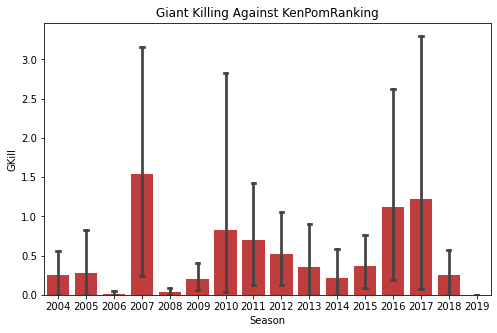

In [350]:
plt.figure(figsize=(8,5))
sns.barplot(y=tour_games['GKill'], x=tour_games['Season'], capsize=0.12, color='tab:red')
plt.title('Giant Killing Against KenPomRanking')
plt.show()

In [351]:
#シードのランクでジャイアントキリングを調べる
idx = tour_games[(tour_games['Seed_Diff']<0)&(tour_games['Hwin']==0)].index
tour_games['GKill'] = 0
tour_games.loc[idx, 'GKill'] = tour_games.loc[idx, 'Seed_Diff']*(-1)

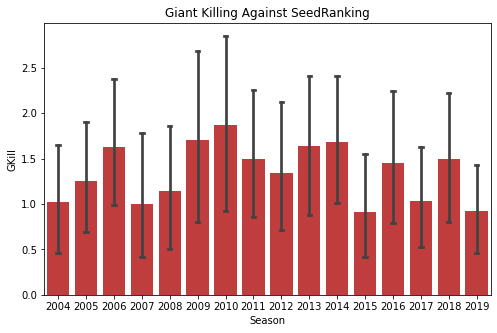

In [352]:
plt.figure(figsize=(8,5))
sns.barplot(y=tour_games['GKill'], x=tour_games['Season'], capsize=0.12, color='tab:red')
plt.title('Giant Killing Against SeedRanking')
plt.show()

In [353]:
easy_year = [2004,2005,2007,2008,2012,2015,2017,2019]
difficult_year = [2006,2009,2010,2013,2014,2016,2018]

In [376]:
all_games_df = pd.read_csv('Data/CreatedData/all_games_kenpom.csv')

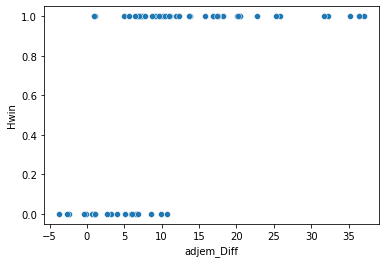

In [291]:
sns.scatterplot(x='adjem_Diff', y='Hwin', data=tour_games[tour_games['Season']==2019])
plt.show()

In [379]:
tour_games = all_games_df[all_games_df['is_tourney']==1].reset_index()

In [381]:
tour_games.columns

Index(['index', 'Season', 'date', 'is_tourney', 'home', 'HTeamID', 'hscore',
       'road', 'RTeamID', 'rscore', 'line', 'lineavg', 'Hwin', 'HSeed',
       'RSeed', 'Hconf', 'Hadjem', 'Hadjo', 'Hadjd', 'Hadjt', 'Hluck', 'Hsche',
       'Hoppo', 'Hoppd', 'Rconf', 'Radjem', 'Radjo', 'Radjd', 'Radjt', 'Rluck',
       'Rsche', 'Roppo', 'Roppd', 'HRankPOM', 'RRankPOM', 'HScore',
       'HOpponentScore', 'HTOmargin', 'HPointMargin', 'HFG', 'HFGopponent',
       'HFG3', 'HFG3opponent', 'HFT', 'Hwins', 'Hwins_top25', 'Hwins_top5',
       'RScore', 'ROpponentScore', 'RTOmargin', 'RPointMargin', 'RFG',
       'RFGopponent', 'RFG3', 'RFG3opponent', 'RFT', 'Rwins', 'Rwins_top25',
       'Rwins_top5', 'Htourny20plus', 'Rtourny20plus', 'HTopConf', 'RTopConf'],
      dtype='object')

In [382]:
tour_games['HRankPOM']

0      24.0
1      28.0
2       6.0
3       1.0
4       7.0
       ... 
990     9.0
991    21.0
992    11.0
993     1.0
994     9.0
Name: HRankPOM, Length: 995, dtype: float64

## 予測のブレンディング

In [816]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [728]:
X_train, y_train, X_val, y_val = prepare_data_nn([2019], 'Hwin', only_tour=True)

In [881]:
#line使う版
features = [
# 'is_tourney',
 'line',
 'lineavg',
# 'Seed_Diff',
# 'adjem_Diff',
# 'adjo_Diff',
# 'adjd_Diff',
# 'adjt_Diff',
# 'luck_Diff',
# 'sche_Diff',
# 'oppo_Diff',
# 'oppd_Diff',
# 'RankPOM_Diff',
 'Score_Diff',
# 'OpponentScore_Diff',
 'TOmargin_Diff',
 'PointMargin_Diff',
 'FG_Diff',
# 'FGopponent_Diff',
# 'FG3_Diff',
# 'FG3opponent_Diff',
# 'FT_Diff',
 'wins_Diff',
 'wins_top25_Diff',
# 'wins_top5_Diff',
 'tourny20plus_Diff',
# 'TopConf_Diff', 
]

In [883]:
#Kenpom使う版
features = [
# 'is_tourney',
# 'line',
# 'lineavg',
# 'Seed_Diff',
 'adjem_Diff',
 'adjo_Diff',
 'adjd_Diff',
# 'adjt_Diff',
 'luck_Diff',
 'sche_Diff',
# 'oppo_Diff',
# 'oppd_Diff',
# 'RankPOM_Diff',
# 'Score_Diff',
# 'OpponentScore_Diff',
 'TOmargin_Diff',
 'PointMargin_Diff',
# 'FG_Diff',
# 'FGopponent_Diff',
 'FG3_Diff',
# 'FG3opponent_Diff',
# 'FT_Diff',
 'wins_Diff',
# 'wins_top25_Diff',
# 'wins_top5_Diff',
 'tourny20plus_Diff',
# 'TopConf_Diff', 
]

In [829]:
def kfold_logistic(seasons, target_col):
    preds = np.array([])
    for season in seasons:
        print('Validation on season {}'.format(season))
        X_train, y_train, X_val, y_val = prepare_data_nn([season], target_col, only_tour=True)
        
        model = LogisticRegression(C=1.0)
        #model = LogisticRegression(penalty='l1', C=1.0, l1_ratio=0.94, solver='saga')
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_val)[:, 1]
        preds = np.concatenate([preds, pred],axis=0)
        print('Logloss:{:.3f}'.format(log_loss(y_val, pred)))
        print('-------------------------')
    return preds

In [882]:
#baseline(using line of all season)
preds_line = kfold_logistic([2016,2017,2018,2019], 'Hwin')

Validation on season 2016
Logloss:0.529
-------------------------
Validation on season 2017
Logloss:0.476
-------------------------
Validation on season 2018
Logloss:0.568
-------------------------
Validation on season 2019
Logloss:0.506
-------------------------


In [884]:
#baseline(using line of all season)
preds_pom = kfold_logistic([2016,2017,2018,2019], 'Hwin')

Validation on season 2016
Logloss:0.450
-------------------------
Validation on season 2017
Logloss:0.486
-------------------------
Validation on season 2018
Logloss:0.580
-------------------------
Validation on season 2019
Logloss:0.454
-------------------------


In [885]:
df_pred = pd.DataFrame([preds_line, preds_pom]).T.rename(columns={0:'pred_line', 1:'pred_pom'})
df_pred.head()

,pred_line,pred_pom
0,0.712386,0.677754
1,0.699013,0.749010
2,0.707003,0.577030
3,0.752449,0.825908
4,0.484315,0.429921


In [886]:
df_ans = all_games_df[(all_games_df['Season'].isin([2016,2017,2018,2019])) & \
             (all_games_df['is_tourney']==1)]['Hwin'].reset_index(drop=True)

In [887]:
#まずは普通にlog-lossを計算してみる
for i in range(df_pred.shape[1]):
    loss = log_loss(df_ans.values, df_pred.values[:, i])
    print('Logloss of {} : {:.5f}'.format(df_pred.columns[i], loss))

Logloss of pred_line : 0.51969
Logloss of pred_pom : 0.49317


In [888]:
#重み最適化を行う
y_val = df_ans.values
predictions = []
lls = []
weights = []
for i in range(df_pred.shape[1]):
    predictions.append(np.array(df_pred.iloc[:, i]))

In [889]:
# Define the objective function to optimize Error by using ScyiPy algorithm.
def logloss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    return log_loss(y_val, final_prediction)

In [890]:
#SLSQP as Solver

# Optimization runs 100 times.
for i in range(100):
    starting_values = np.random.uniform(size=df_pred.shape[1])
    # cons are given as constraints.
    cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
    bounds = [(0,1)]*len(predictions)
    
    res = minimize(logloss_func, starting_values, constraints=cons,
                   bounds = bounds, method='SLSQP')

    lls.append(res['fun'])
    weights.append(res['x'])

In [891]:
bestSC = np.min(lls)
bestWeight = weights[np.argmin(lls)]

print('Ensemble Score: {best_score:.7f}'.format(best_score=bestSC))
print('Best Weights: {weights:}'.format(weights=bestWeight))

Ensemble Score: 0.4931748
Best Weights: [2.77555756e-17 1.00000000e+00]


In [892]:
print('LogLoss: {:.5f}'.format(log_loss(y_val, np.sum(bestWeight * df_pred, axis=1))))

LogLoss: 0.49317


In [893]:
y_val = df_ans.values
predictions = []
lls = []
weights = []
for i in range(df_pred.shape[1]):
    predictions.append(np.array(df_pred.iloc[:, i]))

In [894]:
#L-BFGS-B

for i in range(100):
    starting_values = np.random.uniform(size=df_pred.shape[1])
    bounds = [(0,1)]*len(predictions)
    res = minimize(logloss_func, starting_values, method='L-BFGS-B', 
                   bounds=bounds, options={'disp': False, 'maxiter': 100000})
    lls.append(res['fun'])
    weights.append(res['x'])

In [895]:
bestSC = np.min(lls)
bestWeight = weights[np.argmin(lls)]

print('Ensemble Score: {best_score:.7f}'.format(best_score=bestSC))
print('Best Weights: {weights:}'.format(weights=bestWeight))

Ensemble Score: 0.4924336
Best Weights: [0.         0.98809311]


In [880]:
print('MSE: {:.7f}'.format(log_loss(y_val, np.sum(bestWeight * df_pred, axis=1))))

MSE: 0.4762983
